In [7]:
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time
import cmath
import math

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist, mnist, cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.saving import register_keras_serializable, deserialize_keras_object
from tensorflow.compat.v1 import assign_sub
from matplotlib import cm
from matplotlib.colors import Normalize

from scipy.sparse.linalg import LinearOperator
from scipy.fft import fft, ifft, fft2, ifft2
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict

import autosetup 
from backpropagation import CBP, CBP_decoder, CBP_decoder_v2
from complex_optimizer import Complex_SGD, adaptive_stepsize

In [2]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


## Autoencoder ptygenography

### Loading datasets

#### Import datasets

##### CIFAR10

In [ ]:
# CIFAR10 --> DELETE FOR FINAL VERSION
(x_train_cf, cls_train_cf), (x_test_cf, cls_test_cf) = cifar10.load_data()
rtp = 20 # resolution reduction to
lbl = 9 # choice of type: https://www.cs.toronto.edu/~kriz/cifar.html

# change shapes of labels
cls_train_cf_lbl = tf.squeeze(cls_train_cf) == lbl
cls_test_cf_lbl = tf.squeeze(cls_test_cf) == lbl

x_train_gray = x_train_cf.astype('float32') / 255. #normalize the data
x_test_gray = x_test_cf.astype('float32') / 255.

x_train_gray = tf.image.rgb_to_grayscale(x_train_gray)  # shape: (50000, 32, 32, 1)
x_test_gray = tf.image.rgb_to_grayscale(x_test_gray)

x_train_gray = tf.squeeze(x_train_gray) # remove the color component
x_test_gray = tf.squeeze(x_test_gray)

# filter dataset for lbl to rtp x rtp complex set of dataset
#training
x_train_lbl = x_train_gray[cls_train_cf_lbl.numpy()] 
x_train_lbl = tf.cast(x_train_lbl, tf.float32)
x_train_lbl = tf.squeeze(x_train_lbl)

x_train_temp = x_train_lbl[..., tf.newaxis]
x_train_temp = tf.image.resize(x_train_temp, [rtp,rtp])
x_train_lbl_small = x_train_temp[:,:,:,0]

x_train_lbl_cx_small = tf.complex(np.ones((x_train_lbl_small.shape)).astype('float32'), x_train_lbl_small)

print("Size complex lower resolution training set of only selected label: ", x_train_lbl_cx_small.shape)

#testing
x_test_lbl = x_test_gray[cls_test_cf_lbl.numpy()] 
x_test_lbl = tf.cast(x_test_lbl, tf.float32)
#x_test_lbl = x_test_lbl.astype('float32')
x_test_lbl = tf.squeeze(x_test_lbl)

x_test_temp = x_test_lbl[..., tf.newaxis]
x_test_temp = tf.image.resize(x_test_temp, [rtp,rtp])
x_test_lbl_small = x_test_temp[:,:,:,0]

x_test_lbl_cx_small = tf.complex(np.ones((x_test_lbl_small.shape)).astype('float32'), x_test_lbl_small)

print("Size complex lower resolution testing set of only selected label: ", x_test_lbl_cx_small.shape)

Size complex lower resolution training set of only selected label:  (5000, 20, 20)
Size complex lower resolution testing set of only selected label:  (1000, 20, 20)


##### MNIST & FASHION MNIST

In [3]:
# original dataset MNIST
(x_train, cls_train), (x_test, cls_test) = mnist.load_data()
rtp = 10 #resize the pixel
lbl = 3 #label
lbl_2 = 1 # another label

# dataset fashion MNIST
#(x_train, cls_train), (x_test, cls_test) = fashion_mnist.load_data()
#rtp = 20 # fashion is too blurry with 10 x 10
#lbl = 8 # choice of type: https://pravarmahajan.github.io/fashion/

## prep different datasets
x_train = x_train.astype('float32') / 255. #normalize the data
x_test = x_test.astype('float32') / 255.

print("Size training dataset: ", x_train.shape)
print("Size testing dataset: ", x_test.shape)

# dataset of 10 x 10 or 20 x 20 pixels instead of 28 x 28
x_train_temp = x_train[..., tf.newaxis]
x_train_temp = tf.image.resize(x_train_temp, [rtp,rtp])
x_train_small = x_train_temp[:,:,:,0]

x_test_temp = x_test[..., tf.newaxis]
x_test_temp = tf.image.resize(x_test_temp, [rtp,rtp])
x_test_small = x_test_temp[:,:,:,0]

print("Size lower resolution training set: ", x_train_small.shape)
print("Size lower resolution testing set: ", x_test_small.shape)

# dataset of 10 x 10 pixels as complex images
x_train_cx_small = tf.complex(np.ones((x_train_small.shape)).astype('float32'), x_train_small)
x_test_cx_small = tf.complex(np.ones((x_test_small.shape)).astype('float32'), x_test_small)

print("Size of the complex and lower res training set: ",x_train_cx_small.shape)

# filter dataset for 3's to 10 x 10 complex set of MNIST (label 3 is a dress for fashion MNIST)
#training
x_train_lbl = x_train[np.where(cls_train==lbl),:] 
x_train_lbl = x_train_lbl.astype('float32')
x_train_lbl = tf.squeeze(x_train_lbl)

x_train_temp = x_train_lbl[..., tf.newaxis]
x_train_temp = tf.image.resize(x_train_temp, [rtp,rtp])
x_train_lbl_small = x_train_temp[:,:,:,0]

x_train_lbl_cx_small = tf.complex(np.ones((x_train_lbl_small.shape)).astype('float32'), x_train_lbl_small)

print("Size complex lower resolution training set of only 3's: ", x_train_lbl_cx_small.shape)

#testing
x_test_lbl = x_test[np.where(cls_test==lbl),:] 
x_test_lbl = x_test_lbl.astype('float32')
x_test_lbl = tf.squeeze(x_test_lbl)

x_test_temp = x_test_lbl[..., tf.newaxis]
x_test_temp = tf.image.resize(x_test_temp, [rtp,rtp])
x_test_lbl_small = x_test_temp[:,:,:,0]

x_test_lbl_cx_small = tf.complex(np.ones((x_test_lbl_small.shape)).astype('float32'), x_test_lbl_small)

print("Size complex lower resolution testing set of only 3's: ", x_test_lbl_cx_small.shape)

# filter dataset for SECOND label to 10 x 10 complex set of MNIST (label 3 is a dress for fashion MNIST)
#training
x_train_lbl_2 = x_train[np.where(cls_train==lbl_2),:] 
x_train_lbl_2 = x_train_lbl_2.astype('float32')
x_train_lbl_2 = tf.squeeze(x_train_lbl_2)

x_train_temp = x_train_lbl_2[..., tf.newaxis]
x_train_temp = tf.image.resize(x_train_temp, [rtp,rtp])
x_train_lbl2_small = x_train_temp[:,:,:,0]

x_train_lbl2_cx_small = tf.complex(np.ones((x_train_lbl2_small.shape)).astype('float32'), x_train_lbl2_small)

print("Size complex lower resolution training set of only 1's: ", x_train_lbl2_cx_small.shape)

#testing
x_test_lbl_2 = x_test[np.where(cls_test==lbl_2),:] 
x_test_lbl_2 = x_test_lbl_2.astype('float32')
x_test_lbl_2 = tf.squeeze(x_test_lbl_2)

x_test_temp = x_test_lbl_2[..., tf.newaxis]
x_test_temp = tf.image.resize(x_test_temp, [rtp,rtp])
x_test_lbl2_small = x_test_temp[:,:,:,0]

x_test_lbl2_cx_small = tf.complex(np.ones((x_test_lbl2_small.shape)).astype('float32'), x_test_lbl2_small)

print("Size complex lower resolution testing set of only 1's: ", x_test_lbl2_cx_small.shape)

# COMBINED DATASETS OF LBL AND LBL2
cap = x_train_lbl_small.shape[0]
x_train_2digits = tf.complex(x_train_lbl2_small[:cap], x_train_lbl_small)

cap_test = x_test_lbl_small.shape[0]
x_test_2digits = tf.complex(x_test_lbl2_small[:cap_test], x_test_lbl_small)

Size training dataset:  (60000, 28, 28)
Size testing dataset:  (10000, 28, 28)
Size lower resolution training set:  (60000, 10, 10)
Size lower resolution testing set:  (10000, 10, 10)
Size of the complex and lower res training set:  (60000, 10, 10)
Size complex lower resolution training set of only 3's:  (6131, 10, 10)
Size complex lower resolution testing set of only 3's:  (1010, 10, 10)
Size complex lower resolution training set of only 1's:  (6742, 10, 10)
Size complex lower resolution testing set of only 1's:  (1135, 10, 10)


In [ ]:
## export dataset
export_train = x_train_lbl_cx_small.numpy()
export_test = x_test_lbl_cx_small.numpy()

np.save('CIFAR10_400_only9_train.npy', export_train)
np.save('CIFAR10_400_only9_test.npy', export_test)

In [4]:
## set current dataset
dataset = x_train_lbl_cx_small.numpy()
datatest = x_test_lbl_cx_small.numpy()
dataset_size = dataset.shape[0]
nx = dataset.shape[1]
n = int(nx**2)

print("Shape current dataset using: ", dataset.shape)
print("Length of side: ", nx)

Shape current dataset using:  (6131, 10, 10)
Length of side:  10


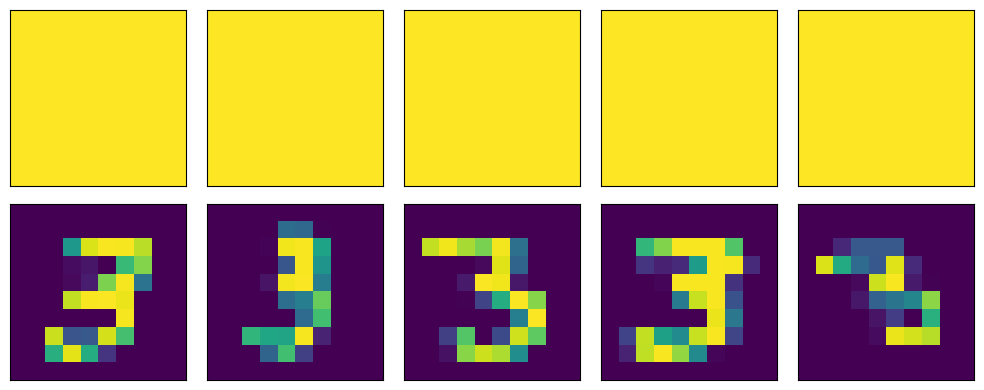

In [5]:
## show samples of the data
ns = 5
fig, ax = plt.subplots(2,ns, figsize=(10,4))

for i in range(ns):
    x = dataset[i]
    ax[0,i].imshow(np.real(x).reshape((nx,nx)),clim=[0,1])
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[1,i].imshow(np.imag(x).reshape((nx,nx)),clim=[0,1])
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
fig.tight_layout(h_pad=0.5)

fig.subplots_adjust(hspace=0.1)

### Training loop

In [6]:
## parameters relevant to training
EPOCHS = 100
dataset_size = dataset.shape[0]
reshape_dataset = tf.reshape(dataset, (dataset_size,-1))
sample_shape = reshape_dataset.shape[-1]                        # data dimension
n = sample_shape 
nx = int(np.sqrt(sample_shape))                                 # one side of the 2D image
midlayer_dim = 50                                               # for MNIST, use (50,10)
latent_dim = 10                                                 # reduction of data 

print("Number of epochs: ", EPOCHS)
print("Dataset size: ", dataset_size)
print("Dimension of one sample: ", sample_shape)
print("Dimension of the middle layer", midlayer_dim)
print("Latent dimension: ", latent_dim)
print("Entire dimensions reshaped dataset: ", reshape_dataset.shape)

Number of epochs:  100
Dataset size:  6131
Dimension of one sample:  100
Dimension of the middle layer 50
Latent dimension:  10
Entire dimensions reshaped dataset:  (6131, 100)


In [ ]:
## wrapper for training - run when training only
@tf.function
def train_step(x, alpha, encoder, decoder, optimizer):
    y = decoder(encoder(x))
    loss_value = autosetup.loss_MSE(y, x)
    grads_and_vars = CBP(x, y, encoder, decoder, autosetup.dLossdaL, autosetup.Jac_caparctan)
    new_alpha = adaptive_stepsize(x, y, alpha, encoder, decoder, autosetup.loss_MSE, grads_and_vars)
    _ = optimizer.apply_gradients(grads_and_vars, alpha = alpha)
    return loss_value, new_alpha

In [ ]:
# run when training a new decoder a new decoder only

train_dataset = (
    tf.data.Dataset.from_tensor_slices(reshape_dataset)
    .shuffle(dataset_size, reshuffle_each_iteration=True) # reshuffle the entire dataset
    .batch(1)
)

encoder = autosetup.ComplexEncoder([midlayer_dim, latent_dim])
decoder = autosetup.ComplexDecoder([midlayer_dim, sample_shape])

# initialize layers: on first call their shape is set based on the shapes of the first data
dummy = tf.zeros((1, sample_shape), dtype=tf.complex64)
_ = decoder(encoder(dummy))

print(type(train_dataset))

optimizer = Complex_SGD()
alpha = 1e-2 # initial value

# for visualization
avg_loss_list = []
samples_loss_list = np.zeros((EPOCHS,10))

for epoch in range(EPOCHS):
    print(f"\nStart of epoch {epoch+1}")
    start_time = time.time()

    count = 0
    epoch_loss = 0.0
    count_sample = 0
    for x in train_dataset:
        alpha = 1e-2 # initial value
        loss, alpha = train_step(x, alpha, encoder, decoder, optimizer)

        count += 1
        epoch_loss += loss.numpy()

        if count % (int(dataset_size/10)) == 0:
            print("Training loss (for one sample) at sample %d: %.4f" % (count, float(loss)))
            samples_loss_list[epoch, count_sample] = loss
            count_sample+= 1

    avg_loss = epoch_loss/(dataset_size)
    avg_loss_list.append(avg_loss)
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.5f}") 
    print("Time taken: %.2fs" % (time.time() - start_time))

<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>

Start of epoch 1
Training loss (for one sample) at sample 613: 28963.0703
Training loss (for one sample) at sample 1226: 10962.6074
Training loss (for one sample) at sample 1839: 824228.6250
Training loss (for one sample) at sample 2452: 255836.7500
Training loss (for one sample) at sample 3065: 345681.0625
Training loss (for one sample) at sample 3678: 199831.5625
Training loss (for one sample) at sample 4291: 99019.2500
Training loss (for one sample) at sample 4904: 14522.8213
Training loss (for one sample) at sample 5517: 26003.4375
Training loss (for one sample) at sample 6130: 16957.7344
Epoch 1 | Loss: 167965.14062
Time taken: 12.01s

Start of epoch 2
Training loss (for one sample) at sample 613: 88754.9688
Training loss (for one sample) at sample 1226: 128244.0000
Training loss (for one sample) at sample 1839: 2558409.5000
Training loss (for one sample) at sample 2452: 999817.8750
Training loss (for one sample) at samp

KeyboardInterrupt: 

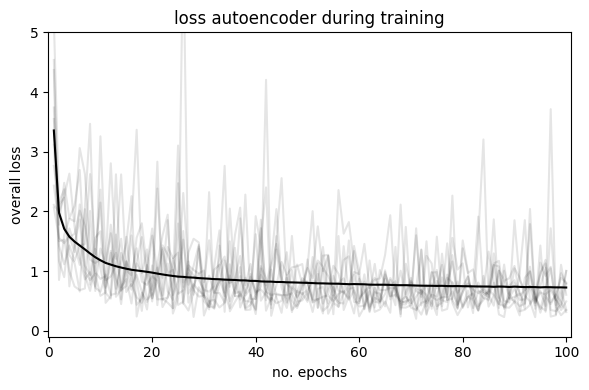

In [ ]:
## plot epochs vs loss over time
fig, ax = plt.subplots(1, figsize = (6,4))

epochplot = np.linspace(1,EPOCHS,100)

ax.plot(epochplot, avg_loss_list, 'k')
ax.plot(epochplot, samples_loss_list, 'k', alpha=1/10)

ax.set_xlabel('no. epochs')
ax.set_ylabel('overall loss')
ax.set_title('loss autoencoder during training')

ax.set_ylim([-0.1, 5])
ax.set_xlim([-0.1,101])

plt.tight_layout()
plt.show()

#### Use random weights pre-training for autoencoder

In [49]:
untrained_encoder = autosetup.ComplexEncoder([midlayer_dim, latent_dim])
untrained_decoder = autosetup.ComplexDecoder([midlayer_dim, sample_shape])

# initialize layers: on first call their shape is set based on the shapes of the first data
dummy = tf.zeros((1, sample_shape), dtype=tf.complex64)
_ = untrained_decoder(untrained_encoder(dummy))

#### Weights saving

In [ ]:
## save the encoder weights (not needed for least squares but helpful in generating examples)
wrap_encoder = autosetup.EncoderSave(encoder)
_ = wrap_encoder(tf.zeros((1, sample_shape), dtype = tf.complex64))

wrap_encoder.save_weights("encoder_100epochs_X3train_k10_grad2_arctan_run2.weights.h5")

In [316]:
## save the decoder weights
wrap_decoder = autosetup.DecoderSave(decoder)
_ = wrap_decoder(tf.zeros((1, latent_dim), dtype = tf.complex64))

wrap_decoder.save_weights("decoder_100epochs_X3train_k10_grad2_arctan_run2.weights.h5")

In [8]:
## load the encoder weights
encoder_from_load = autosetup.ComplexEncoder([midlayer_dim, latent_dim])
encoder_model_from_load = autosetup.EncoderSave(encoder_from_load)

## load the decoder weights
decoder_from_load = autosetup.ComplexDecoder([midlayer_dim, sample_shape])
model_from_load = autosetup.DecoderSave(decoder_from_load)

# build
dummy_enc = tf.zeros((1, sample_shape), dtype = tf.complex64)
_ = encoder_from_load(dummy_enc)
_ = encoder_model_from_load(dummy_enc)

dummy_dec = tf.zeros((1, latent_dim), dtype = tf.complex64)
_ = decoder_from_load(dummy_dec)
_ = model_from_load(tf.zeros((1, latent_dim), dtype = tf.complex64))

# load
#model_from_load.load_weights("saved_decoder_test.weights.h5")
model_from_load.load_weights("decoder_100epochs_X3train_k10_grad2_arctan.weights.h5")
encoder_model_from_load.load_weights("encoder_100epochs_X3train_k10_grad2_arctan.weights.h5")

In [9]:
## run if decoder should be loaded from save
encoder = encoder_model_from_load.encoder
decoder = model_from_load.decoder

#### Extracting and wrapping autoencoder function

In [10]:
# support functions generative map
def make_tensor_shape(z):
    tensor_z = tf.convert_to_tensor(z, dtype=tf.complex64)
    return tf.reshape(tensor_z,[1,-1])

def make_tensor(z):
    return tf.convert_to_tensor(z, dtype=tf.complex64)

# wrapper for decoder to numpy function
def decoderfunc_1D(z, decoder):
    '''
    Converts the autoencoder.decoder function into a generative embedding function

    input:
        z:              np.array of length (latent_dim)
        decoder:        custom class autosetup.ComplexDecoder, numpy.array(sample size, latent_dim) --> tensor(sample size, dim^2))    

    output:
        decoderfunc_1D: function that maps z to numpy array of lenght dim^2 (flattened original image). flatten() ensures shape (n,) and not (1,n)
    '''
    return decoder(tf.reshape(make_tensor(z), [1,-1])).numpy().flatten()

# wrapper for Jacobian computation to numpy function
def jac_decoder_1D(z, decoder, type = "normal"):
    '''
    Converts the CBP_decoder computation into a numpy function, outputting the R or R*-derivative of the decoder in z as a numpy array
    NOTE: activation function is hardcoded at this point
    NOTE: CBP_decoder_v2 makes a comparable computation but a slightly different order of partial derivative computation. It seems to give the same result

    input:
        z:              np.array of length (latent_dim)
        decoder:        custom class autosetup.ComplexDecoder, numpy.array(sample size, latent_dim) --> tensor(sample size, dim^2))
        type:           str, either "normal" or "conj", indicating the R or the R*-derivative
    '''
    dG_dz, dG_dzstar = CBP_decoder(tf.reshape(make_tensor(z), [1,-1]), decoder, autosetup.Jac_caparctan)
    if type == "normal":
        return dG_dz.numpy()
    elif type == "conj":
        return dG_dzstar.numpy()
    else:
        raise ValueError(f"Invalid type '{type}. Must be 'normal' or 'conj'.")        

# comparison plot between ground truth and approximation
def plot_result(xtrue, xhat):
    n  = len(xtrue)
    nx = int(np.sqrt(n))
    
    # plot results
    fig, ax = plt.subplots(2,2)

    ax[0,0].imshow(np.real(xtrue.reshape((nx,nx))),clim=[0,1])
    ax[0,0].set_title(r'$\Re(x_{true})$')
    ax[1,0].imshow(np.imag(xtrue.reshape((nx,nx))),clim=[0,1])
    ax[1,0].set_title(r'$\Im(x_{true})$')
    ax[0,1].imshow(np.real(xhat.reshape((nx,nx))),clim=[0,1])
    ax[0,1].set_title(r'$\Re(x_{est})$')
    ax[1,1].imshow(np.imag(xhat.reshape((nx,nx))),clim=[0,1])
    ax[1,1].set_title(r'$\Im(x_{est})$')

    fig.tight_layout()

#### Testing quality of encoder and decoder

tf.Tensor(9.932264, shape=(), dtype=float32)


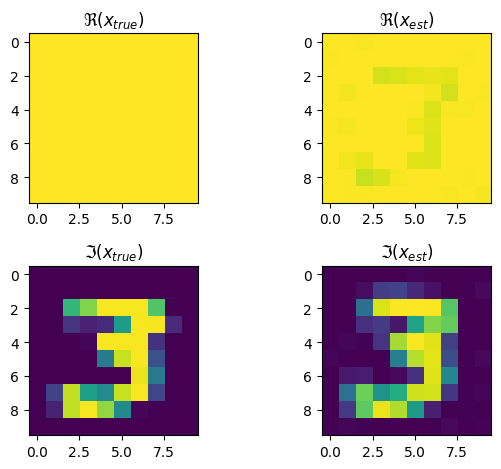

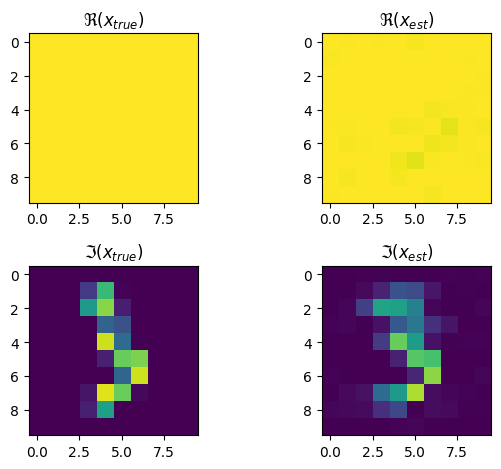

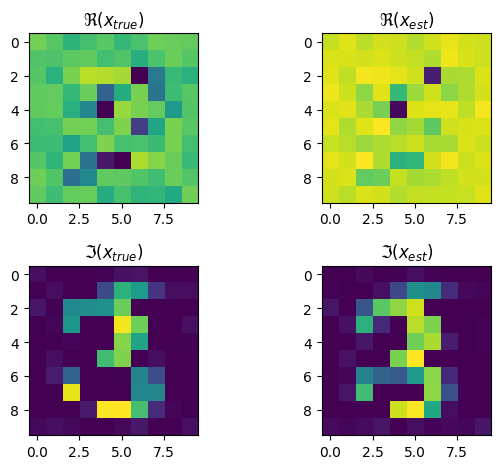

In [ ]:
# training and test image --> DELETE FOR FINAL VERSION
i = 3
train_ex = reshape_dataset[i]
test_ex = datatest[i]
test_encoder = encoder
test_decoder = decoder

encoded_ex_train = test_encoder(make_tensor_shape(train_ex))
decoded_ex_train = test_decoder(encoded_ex_train)

encoded_ex_test = test_encoder(make_tensor_shape(test_ex))
decoded_ex_test = test_decoder(encoded_ex_test)

x_train_plot_ex = train_ex.numpy().flatten()
x_train_recon_ex = decoded_ex_train.numpy().flatten()

x_test_plot_ex = test_ex.flatten()
x_test_recon_ex = decoded_ex_test.numpy().flatten()

plot_result(x_train_plot_ex, x_train_recon_ex)
plot_result(x_test_plot_ex, x_test_recon_ex)

# testoutput PCA
# x_pca = np.load('outputPCA.npy')
# x_pca_recon = test_decoder(test_encoder(make_tensor_shape(x_pca)))

# x_pca_plot = x_pca.flatten()
# x_pca_recon_plot = x_pca_recon.numpy().flatten()

# plot_result(x_pca_plot, x_pca_recon_plot)
# print(autosetup.loss_MSE(x_pca_plot, x_pca_recon_plot))

# testoutput decoder
x_decod = G.eval(np.random.randn(k) + 1j*np.random.randn(k))
x_decod_recon = test_decoder(test_encoder(make_tensor_shape(x_decod)))

x_decod_plot = x_decod.flatten()
x_decod_recon_plot = x_decod_recon.numpy().flatten()

plot_result(x_decod_plot, x_decod_recon_plot)
print(autosetup.loss_MSE(x_decod_plot, x_decod_recon_plot))

In [ ]:
## average quality of the autoencoder
errors_train = []
errors_test = []

for i in range(1000):
    train_ex = reshape_dataset[i]
    test_ex = datatest[i]
    test_encoder = encoder
    test_decoder = decoder

    encoded_ex_train = test_encoder(make_tensor_shape(train_ex))
    decoded_ex_train = test_decoder(encoded_ex_train)

    encoded_ex_test = test_encoder(make_tensor_shape(test_ex))
    decoded_ex_test = test_decoder(encoded_ex_test)

    x_train_plot_ex = train_ex.numpy().flatten()
    x_train_recon_ex = decoded_ex_train.numpy().flatten()

    x_test_plot_ex = test_ex.flatten()
    x_test_recon_ex = decoded_ex_test.numpy().flatten()

    error_train = autosetup.loss_MSE(x_train_recon_ex, x_train_plot_ex)
    error_test = autosetup.loss_MSE(x_test_recon_ex, x_test_plot_ex)

    errors_train.append(error_train)
    errors_test.append(error_test)

print(np.argmax(errors_train))
print(np.argmin(errors_train))

print(np.argmax(errors_test))
print(np.argmin(errors_test))

print(np.mean(errors_train))
print(np.mean(errors_test))


888
912
745
158
0.86888146
0.85376924


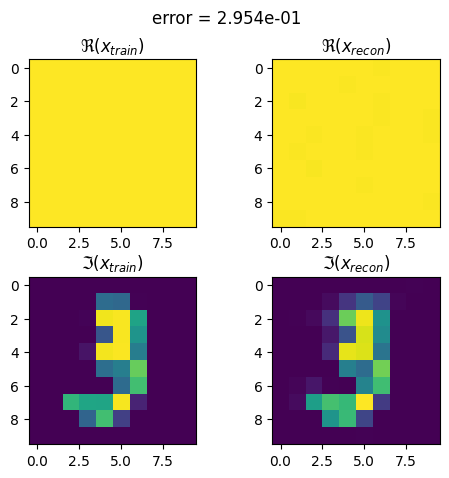

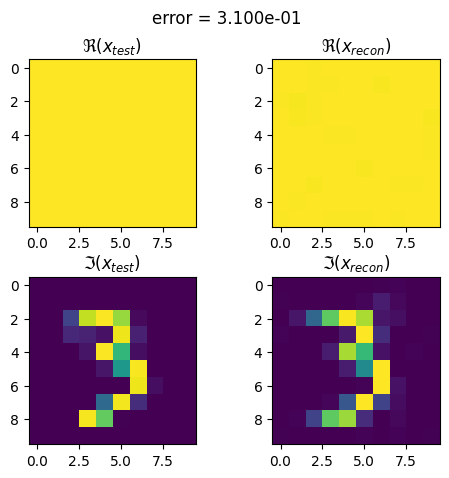

In [10]:
# training and test image, but with custom titles & plots
i = 1
train_ex = reshape_dataset[i]
test_ex = datatest[i]
test_encoder = encoder
test_decoder = decoder

encoded_ex_train = test_encoder(make_tensor_shape(train_ex))
decoded_ex_train = test_decoder(encoded_ex_train)

encoded_ex_test = test_encoder(make_tensor_shape(test_ex))
decoded_ex_test = test_decoder(encoded_ex_test)

x_train_plot_ex = train_ex.numpy().flatten()
x_train_recon_ex = decoded_ex_train.numpy().flatten()

x_test_plot_ex = test_ex.flatten()
x_test_recon_ex = decoded_ex_test.numpy().flatten()

error_train = autosetup.loss_MSE(x_train_recon_ex, x_train_plot_ex)
error_test = autosetup.loss_MSE(x_test_recon_ex, x_test_plot_ex)

# VISUALIZE TRAINING IMAGE
fig, ax = plt.subplots(2,2, figsize=(6,5))

ax[0,0].imshow(np.real(x_train_plot_ex.reshape((nx,nx))),clim=[0,1])
ax[0,0].set_title(r'$\Re(x_{train})$')
ax[1,0].imshow(np.imag(x_train_plot_ex.reshape((nx,nx))),clim=[0,1])
ax[1,0].set_title(r'$\Im(x_{train})$')
ax[0,1].imshow(np.real(x_train_recon_ex.reshape((nx,nx))),clim=[0,1])
ax[0,1].set_title(r'$\Re(x_{recon})$')
ax[1,1].imshow(np.imag(x_train_recon_ex.reshape((nx,nx))),clim=[0,1])
ax[1,1].set_title(r'$\Im(x_{recon})$')

fig.suptitle(rf"error = {error_train:.3e}")
#fig.tight_layout(h_pad=0.5)

#plt.subplots_adjust(hspace=0.01, wspace=0.1)
fig.subplots_adjust(hspace=0.3, wspace=0.1)

# VISUALIZE TESTING IMAGE
fig, ax = plt.subplots(2,2, figsize=(6,5))

ax[0,0].imshow(np.real(x_test_plot_ex.reshape((nx,nx))),clim=[0,1])
ax[0,0].set_title(r'$\Re(x_{test})$')
ax[1,0].imshow(np.imag(x_test_plot_ex.reshape((nx,nx))),clim=[0,1])
ax[1,0].set_title(r'$\Im(x_{test})$')
ax[0,1].imshow(np.real(x_test_recon_ex.reshape((nx,nx))),clim=[0,1])
ax[0,1].set_title(r'$\Re(x_{recon})$')
ax[1,1].imshow(np.imag(x_test_recon_ex.reshape((nx,nx))),clim=[0,1])
ax[1,1].set_title(r'$\Im(x_{recon})$')

fig.suptitle(rf"error = {error_test:.3e}")
#fig.tight_layout()

fig.subplots_adjust(hspace=0.3, wspace=0.1)

### Integrate with least squares signal optimization

In [11]:
## least-squares minimization, modified from Aslan et al., PtyGenographyusing generative models for regularization of the phase retrieval problem (2025)
class Op:
    def __init__(self, fun, jac, shape):
        self.eval = fun
        self.jac = jac
        self.shape = shape
        
def objective(z, y, A, Astar, D, Dstar, w=1, lmbda = 0):
    """
    LS objective
        (0.5)*\|A(G(z)) - y\|_2^2 + 0.5*lmbda**2*\|w*z\|_2^2
    """
    if len(y) != A.shape[0]:
        print("y and A don't match")
        return
    if len(z)//2 != D.shape[1]:
        print("z and G don't match")
        return
    if A.shape[1] != D.shape[0]:
        print("A and G don't match!")
        return
    
    k  = len(z)//2
    zc = z[:k] + 1j*z[k:]

    xc = D.eval(zc)
    Dx = D.jac(zc)
    Dxstar = Dstar.jac(zc)
    
    yp = A.eval(xc)
    Dy = A.jac(xc)
    Dystar = Astar.jac(xc)

    #DFstar_T = Dxstar.T@Dy.T + Dx.H@Dystar.T
    #DF_H = Dx.H@Dy.H + Dxstar.T@Dystar.H

    val    = (0.5)*np.linalg.norm(yp - y)**2 + (0.5*lmbda**2)*np.linalg.norm(w*zc)**2
    #gradc  = 2*Dx.H@(Dy.H@(yp - y)) + (lmbda**2)*(w*w)*zc
    #gradc  = 2*DF@(yp - y) + (lmbda**2)*(w*w)*zc
    #gradc = (Dxstar).T@(Dy.T@np.conj(yp - y)) + Dx.H@(Dy.H@(yp - y))

    #gradc = DFstar_T@np.conj(yp - y) + DF_H@(yp - y)
    
    # can't factorize because of the linearoperator class does not recognize the composed operators
    gradc = (Dxstar.T@(Dy.T@np.conj(yp - y))) + (Dx.H@(Dystar.T@np.conj(yp - y))) + Dx.H@(Dy.H@(yp - y)) + Dxstar.T@(Dystar.H@(yp - y)) + (lmbda**2)*(w*w)*zc

    # print("val", val)
    # print("first element gradc", gradc[0])
    
    grad  = np.concatenate((np.real(gradc), np.imag(gradc)))
    
    return val, grad

def reconstruct(xtrue, A, Astar, G, Gstar, w=1, sigma=0, lmbda=0):
    # sizes
    m,n = A.shape
    n,k = G.shape
    
    # generate data
    yobs  = A.eval(xtrue) + sigma*np.random.randn(m)

    # inference
    guess_z0 = np.concatenate([np.ones(k), np.ones(k)]) # can add 0.5 to initial value
    #fake_z0_tf = encoder(make_tensor_shape(xtrue))
    #fake_z0_cx = fake_z0_tf.numpy().flatten()
    #fake_z0 = np.concatenate([np.real(fake_z0_cx), np.imag(fake_z0_cx)])

    result = minimize(objective, x0=guess_z0, args=(yobs, A, Astar, G, Gstar, w, lmbda), method='L-BFGS-B', jac=True, options={
        'maxiter': 10000,      # total outer iterations
        'maxls': 30,          # line search steps per iteration
        'ftol' : 1e-16,
        'gtol': 1e-16,         # gradient tolerance
        'disp': True          # print optimization log
    })
    
    # result = minimize(objective, np.concatenate([np.ones(k), 0.5*np.ones(k)]), args=(yobs, A, G, w, lmbda), method='Powell', jac=True, options={
    #     'maxiter': 1000,      # total outer iterations
    #     'ftol' : 1e-10,
    #     'disp': True          # print optimization log
    # })

    # result
    zhat = result.x[:k] + 1j*result.x[k:]
    xhat = G.eval(zhat)

    #print("zhat", zhat)
    #print("xhat", xhat)

    # print("Result message:", result.message)
    # print("Result status:", result.status)
    # print("Function evals:", result.nfev)
    # print("Jacobian evals:", result.njev)
    # print("Final gradient norm:", np.linalg.norm(result.jac))
    
    # correct global phase
    phi = np.mean(np.angle(xtrue/(xhat + 1e-16*np.ones_like(xhat)))) # avoid division by zero for bad reconstructions
    #phi = np.mean(np.angle(xtrue/xhat)) 
    xhat_corr = np.exp(1j*phi)*xhat
    
    # relative error
    error = np.linalg.norm(xhat_corr - xtrue)/np.linalg.norm(xtrue)
    
    # return
    return error, xhat_corr, yobs, zhat

In [12]:
def MaskedFourier(M):
    """
    Defined masked 2D fourier transform as linear operator.
    
    input:
        M - 3D array of size n x n x m containing m masks of size n x n
        
    out:
        A - linear operator representing the masked Fourier transforms
        
    
    """
    nx = M.shape[0]
    mx = M.shape[2]
    
    mv  = lambda x : fft2(M*(x.reshape((nx,nx,1))), axes=(0,1)).flatten()
    rmv = lambda y : nx*nx*np.sum(np.conj(M)*ifft2(y.reshape((nx,nx,mx)), axes=(0,1)),axis=2).flatten()
    A   = LinearOperator((mx*nx*nx, nx*nx), matvec=mv, rmatvec=rmv) # rmatvec is conjugate operation, so A^H * v
    
    return A

In [13]:
# define forward operator with binary masks
mx = 100       # number of masks
m  = mx * n

M = np.random.randn(nx,nx,mx)
M[M<0]=0
M[M>0]=1

MF   = MaskedFourier(M)
Afun = lambda x : np.abs(MF@x)**2
#Ajac = lambda x : LinearOperator((m, n), matvec=lambda z : (MF@x)*np.conj(MF@np.conj(z)), rmatvec=lambda z : (MF.H@((MF@x)*z)))
Ajac = lambda x : LinearOperator((m, n), matvec=lambda z : np.conj(MF@x)*(MF@z), rmatvec=lambda z : (MF.H@((MF@x)*z)))

A    = Op(fun = Afun, jac = Ajac, shape=(m,n))

# swapped conjugate operator
Ajac_star = lambda x : LinearOperator((m, n), matvec=lambda z : (MF@x)*np.conj(MF@np.conj(z)), rmatvec=lambda z : MF.T@(np.conj(MF@x)*z))
Astar = Op(fun = Afun, jac = Ajac_star, shape=(m,n))

In [14]:
## get prior from decoder
k               = latent_dim
block_identity  = lambda mat : np.concatenate((mat, np.eye(n)), axis=1)
block_zeros     = lambda mat : np.concatenate((mat, np.zeros((n,n))), axis=1)
decoder_op      = decoder # choose untrained_decoder for experiments with random weights


#define generative models
I = Op(fun = lambda z : z, jac = lambda z: LinearOperator((n, n), matvec = lambda z : z, rmatvec = lambda z : z), shape=(n,n))

Istar = Op(fun = lambda z : z, jac = lambda z: LinearOperator((n, n), matvec = lambda z : np.zeros_like(z), rmatvec = lambda z : np.zeros_like(z)), shape=(n,n))

G = Op(fun = lambda z : decoderfunc_1D(z, decoder_op), 
       jac = lambda z : LinearOperator((n,k), matvec = lambda v : jac_decoder_1D(z, decoder_op) @ v, 
                                       rmatvec = lambda p : np.conj(jac_decoder_1D(z, decoder_op).T) @ p),
       shape = (n,k))

Gstar = Op(fun = lambda z : decoderfunc_1D(z, decoder_op), 
       jac = lambda z : LinearOperator((n,k), matvec = lambda v : jac_decoder_1D(z, decoder_op, type="conj") @ v, 
                                       rmatvec = lambda p : np.conj(jac_decoder_1D(z, decoder_op, type="conj").T) @ p),
       shape = (n,k))

H = Op(fun = lambda z : decoderfunc_1D(z[:k], decoder_op) + z[k:], 
       jac = lambda z : LinearOperator((n,k+n), matvec = lambda v : block_identity(jac_decoder_1D(z[:k], decoder_op)) @ v, 
                                       rmatvec = lambda p : np.conj(block_identity(jac_decoder_1D(z[:k], decoder_op)).T) @ p),
       shape = (n,k+n))

# not 100% sure about this one
Hstar = Op(fun = lambda z : decoderfunc_1D(z[:k], decoder_op) + z[k:], 
       jac = lambda z : LinearOperator((n,k+n), matvec = lambda v : block_zeros(jac_decoder_1D(z[:k], decoder_op, type="conj")) @ v, 
                                       rmatvec = lambda p : np.conj(block_zeros(jac_decoder_1D(z[:k], decoder_op, type ="conj")).T) @ p),
       shape = (n,k+n))

# define weights
w = 1

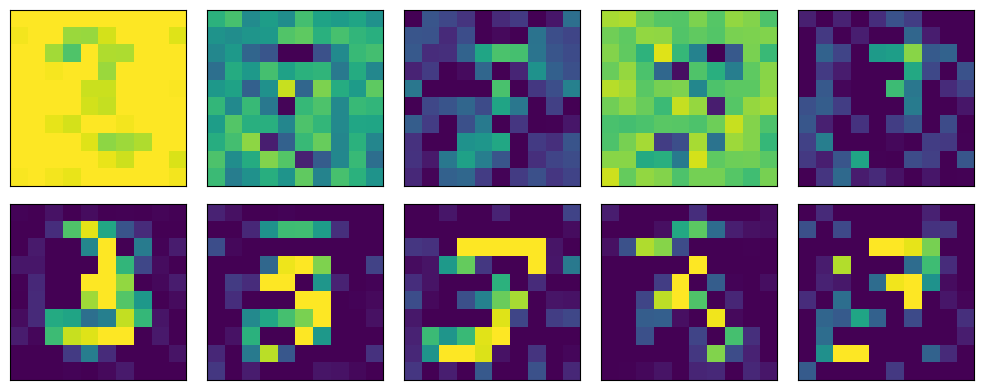

In [15]:
ns = 5
fig, ax = plt.subplots(2,ns, figsize=(10,4))

for i in range(ns):
    z = np.random.randn(k) + 1j*np.random.randn(k)
    x = G.eval(z)
    ax[0,i].imshow(np.real(x).reshape((nx,nx)),clim=[0,1])
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[1,i].imshow(np.imag(x).reshape((nx,nx)),clim=[0,1])
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
fig.tight_layout()

fig.subplots_adjust(hspace=0.1)

#### Testing the reconstruction with least squares

##### Gradient tests

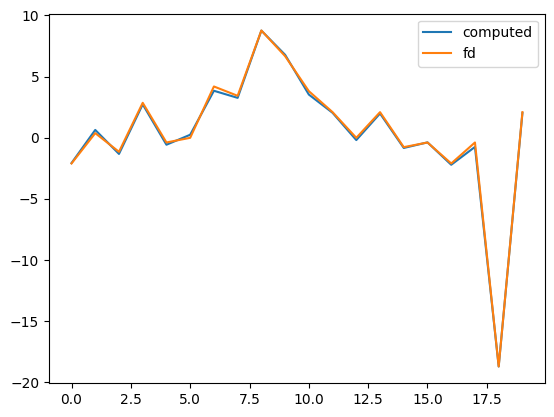

In [ ]:
# test J(z) = 0.5 ||G(z)||_2^2
k_test=10

def test(z):
  k_test = len(z)//2
  zc  = z[:k_test] + 1j*z[k_test:]
  x   = decoderfunc_1D(zc, decoder)
 
  val = 0.5*np.linalg.norm(x)**2 
  #gradc = jac_decoder_1D(zc, decoder,type="normal").T@np.conj(x) - jac_decoder_1D(zc, decoder,type="conj").T@x
  
  gradc = jac_decoder_1D(zc, decoder,type="conj").T@np.conj(x) + np.conj(jac_decoder_1D(zc, decoder,type="normal")).T@x

  return val, np.concatenate((np.real(gradc), np.imag(gradc)))
 
z = np.random.randn(2*k_test)
h = 1e-5
 
val, grad = test(z)
grad_fd = np.zeros(2*k_test)
for i in range(2*k_test):
    e = np.zeros(2*k_test)
    e[i] = 1
    
    grad_fd[i] = (test(z+h*e)[0] - test(z-h*e)[0])/(2*h)
 
plt.plot(grad, label='computed')
plt.plot(grad_fd, label='fd')
plt.legend()

norm difference 0.0315618059386659
grad [-3.51584825  6.50758498  1.14353251  7.09072079  7.18945018 -0.65256639
  5.77645903  4.16147617  2.93459809  4.10324266 -3.84531495  5.85235333
  5.36154758 -4.09745455  5.95953726  4.06606654  3.58368941 -1.33440588
  5.7494687  -2.1104235 ]


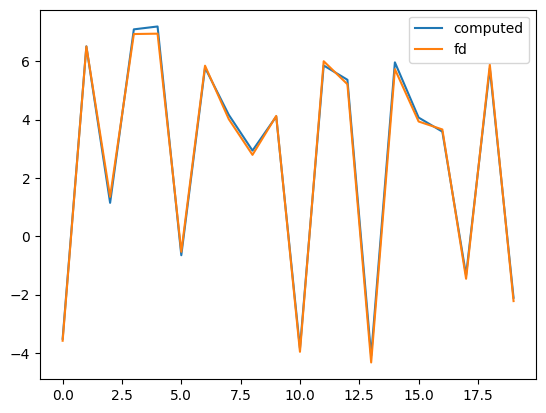

In [ ]:
# gradient test for || G(z) - x ||_2^2 custom defined
h = 1e-5

#np.random.seed(1)
#k  = G.shape[1]
#zt = np.random.randn(2*k)
#yt = np.random.randn(I.shape[0])

k_test  = G.shape[1]


# ||G(z) - x ||_2^2
def bias_obj(z, x_obs): 
  k_test = len(z)//2
  n = len(x_obs)//2
  zc  = z[:k_test] + 1j*z[k_test:]
  xc_obs = x_obs[:n] + 1j*x_obs[n:]

  xc   = decoderfunc_1D(zc, decoder) # G(z)
 
  val = 0.5*np.linalg.norm(xc - xc_obs)**2 
  #gradc = jac_decoder_1D(zc, decoder,type="normal").T@np.conj(x) - jac_decoder_1D(zc, decoder,type="conj").T@x
  
  gradc = jac_decoder_1D(zc, decoder,type="conj").T@np.conj(xc - xc_obs) + np.conj(jac_decoder_1D(zc, decoder,type="normal")).T@(xc - xc_obs)

  return val, np.concatenate((np.real(gradc), np.imag(gradc)))

zt = np.random.randn(2*k_test)
xt = np.random.randn(2*(I.shape[0])) 


val, grad = bias_obj(zt, xt)

grad_fd = np.zeros(2*k_test)
for i in range(2*k_test):
    e = np.zeros(2*k_test)
    e[i] = 1
    
    grad_fd[i] = (bias_obj(zt+h*e, xt)[0] - bias_obj(zt-h*e, xt)[0])/(2*h)


print("norm difference", np.linalg.norm(grad_fd - grad) / np.linalg.norm(grad))
print("grad", grad)

plt.plot(grad, label='computed')
plt.plot(grad_fd, label='fd')
plt.legend()

n 10000
x (100,)
y (10000,)
DA.T (100, 10000)
DG (100, 10)
DG_star.T (10, 100)
x (100,)
y (10000,)
DA.T (100, 10000)
DG (100, 10)
DG_star.T (10, 100)
x (100,)
y (10000,)
DA.T (100, 10000)
DG (100, 10)
DG_star.T (10, 100)
x (100,)
y (10000,)
DA.T (100, 10000)
DG (100, 10)
DG_star.T (10, 100)
x (100,)
y (10000,)
DA.T (100, 10000)
DG (100, 10)
DG_star.T (10, 100)
x (100,)
y (10000,)
DA.T (100, 10000)
DG (100, 10)
DG_star.T (10, 100)
x (100,)
y (10000,)
DA.T (100, 10000)
DG (100, 10)
DG_star.T (10, 100)
x (100,)
y (10000,)
DA.T (100, 10000)
DG (100, 10)
DG_star.T (10, 100)
x (100,)
y (10000,)
DA.T (100, 10000)
DG (100, 10)
DG_star.T (10, 100)
x (100,)
y (10000,)
DA.T (100, 10000)
DG (100, 10)
DG_star.T (10, 100)
x (100,)
y (10000,)
DA.T (100, 10000)
DG (100, 10)
DG_star.T (10, 100)
x (100,)
y (10000,)
DA.T (100, 10000)
DG (100, 10)
DG_star.T (10, 100)
x (100,)
y (10000,)
DA.T (100, 10000)
DG (100, 10)
DG_star.T (10, 100)
x (100,)
y (10000,)
DA.T (100, 10000)
DG (100, 10)
DG_star.T (10, 100

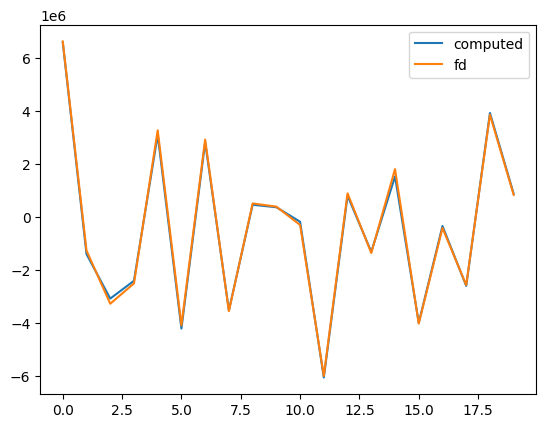

In [ ]:
# gradient test for || A(G(z)) - y ||_2^2 custom defined
h = 1e-5

np.random.seed(1)
#k  = G.shape[1]
#zt = np.random.randn(2*k)
#yt = np.random.randn(I.shape[0])

def test(z, yobs):
  k_test = len(z)//2
  zc  = z[:k_test] + 1j*z[k_test:]
  x   = decoderfunc_1D(zc, decoder)
  y   = A.eval(x)

  print("x", x.shape)
  print("y", y.shape)

  DA = A.jac(x)
  DG = jac_decoder_1D(zc, decoder,type="normal")
  DG_star = jac_decoder_1D(zc, decoder,type="conj")

  print("DA.T", DA.T.shape)
  print("DG", DG.shape)
  print("DG_star.T", DG_star.T.shape)

 
  val = 0.5*np.linalg.norm(y - yobs)**2 
  
  gradc = 2*(DG_star).T@(DA.T@(y - yobs)) + 2*np.conj(DG).T@(DA.H@(y - yobs))

  return val, np.concatenate((np.real(gradc), np.imag(gradc)))

N = A.shape[0]
print("n", N)
z = np.random.randn(2*k_test)
yobs = np.random.randn(N)
val, grad = test(z, yobs)

grad_fd = np.zeros(2*k_test)
for i in range(2*k_test):
    e = np.zeros(2*k_test)
    e[i] = 1
    
    grad_fd[i] = (test(z+h*e, yobs)[0] - test(z-h*e, yobs)[0])/(2*h)

print("norm difference", np.linalg.norm(grad_fd - grad) / np.linalg.norm(grad))
print("grad", grad)

plt.plot(grad, label='computed')
plt.plot(grad_fd, label='fd')
plt.legend()

norm difference 0.0028991209899084376
grad [-2.30751897e+07  9.26942279e+06 -2.14322049e+08  1.82653052e+08
 -1.77239058e+08 -8.14240664e+07  6.91827198e+07 -1.09249493e+08
 -4.22241582e+07 -5.40813553e+07  4.86902989e+07  2.36288351e+08
  6.18393368e+06 -1.00358618e+08  6.04571351e+07 -6.34928642e+07
 -3.65354717e+06  1.09533494e+08 -1.75470023e+08  2.48458425e+07]


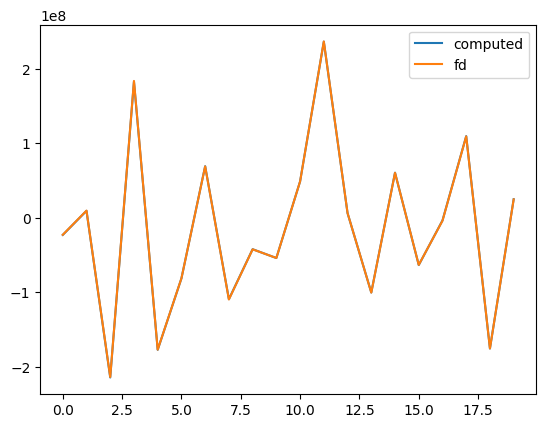

In [16]:
# gradient test for 0.5*|| A(G(z)) - y ||_2^2 from objective (or 0.5|| A(x) - y ||_2^2 or 0.5|| G(z) - x ||_2^2)
h = 1e-5

np.random.seed(2)
#k  = G.shape[1]
#zt = np.random.randn(2*k)
#yt = np.random.randn(I.shape[0])

k_test  = G.shape[1]
zt = np.random.randn(2*k_test)
yt = np.random.randn(A.shape[0])

obj = lambda z : objective(z, yt, A, Astar, G, Gstar, w=1, lmbda=1e4)

val, grad = obj(zt)

grad_fd = np.zeros(2*k_test)
for i in range(2*k_test):
    e = np.zeros(2*k_test)
    e[i] = 1
    
    grad_fd[i] = (obj(zt+h*e)[0] - obj(zt-h*e)[0])/(2*h)


print("norm difference", np.linalg.norm(grad_fd - grad) / np.linalg.norm(grad))
print("grad", grad)

plt.plot(grad, label='computed')
plt.plot(grad_fd, label='fd')
plt.legend()

##### Individual reconstruction tests

Reconstruction error (sigma = 1e-06):  0.1890223014685239


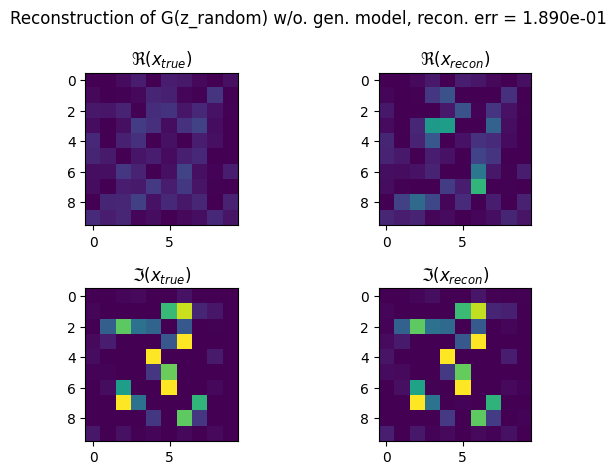

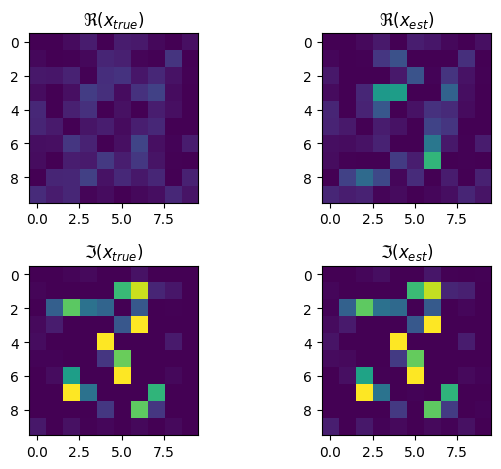

In [23]:
## tests of reconstruct with and without generative model
sigma = 1e-6

#xtrue = dataset[np.random.randint(0,dataset.shape[0])]

#x_random = np.random.normal(size=(1,sample_shape)) + 1j*np.random.normal(size=(1,sample_shape))
#x_tensor = make_tensor(x_random)
#x_random_recon_tf = decoder(encoder(x_tensor)) 
#x_random_recon = x_random_recon_tf.numpy().flatten()
#xtrue_1D = x_random_recon

#xdatatest = datatest[np.random.randint(0,datatest.shape[0])]
#xtrue_1D = xdatatest.flatten()


xtrue = G.eval(np.random.randn(k) + 1j*np.random.randn(k)) #+ 1e3*(np.random.randn(n)+1j*np.random.randn(n))
#print(xtrue.shape)
#print(np.min(np.real(xtrue)))
#xtrue = xtrue - np.min(np.real(xtrue))

#x_load = np.load('G(z)_ex8_goodex.npy')  #x_random_recon #xtrue.flatten()
#xtrue_1D = x_load - np.min((np.real(x_load)))
#x_imag = np.load('autoenc(x)_ex1.npy') 
#x_bad = np.load('G(z)_ex2.npy')

#xtrue_1D = np.zeros(n) + 1j*np.imag(x_bad)

#plot_result(np.abs(x_load), np.abs(x_bad))

xtrue_1D = xtrue.flatten() #x_random.flatten() # #G.eval(np.random.randn(k) + 1j*np.random.randn(k))
#xtrue_1D = np.ones(n) + 1j*np.imag(x_imag)
#xtrue_1D = np.random.randn(n) + 1j*np.random.normal(size=(n))

# phase object in original dim
# phases = np.random.uniform(0, 2*np.pi, sample_size)
# x_random = np.exp(1j*phases)
# x_tensor = make_tensor_shape(x_random)
# print(x_tensor.shape)
# x_random_recon_tf = untrained_decoder(untrained_encoder(x_tensor)) 
# x_random_recon = x_random_recon_tf.numpy().flatten()
# xtrue_1D = x_random_recon

# phase object in latent space
# phases = np.random.uniform(0, 2*np.pi, latent_dim)
# rng = np.random.default_rng(99)
# GM    = rng.normal(0,1/n,size=(n,k))
# Gsing = np.linalg.svd(GM, full_matrices=False, compute_uv=False, hermitian=False)
# while Gsing[-1] < 1e-4: # check for small singular values
#     GM  = np.random.normal(0,10/n,size=(n,k))
#     Gsing = np.linalg.svd(GM, full_matrices=False, compute_uv=False, hermitian=False)
# linear_G = lambda z: GM@z 
# phases_long = linear_G(phases)

# xtrue_1D = np.exp(1j*phases_long)

# print(np.mean(phases_long))
# print(np.mean(np.abs(xtrue_1D)))

error, xhat_corr, yobs, result = reconstruct(xtrue_1D, A, Astar, I, Istar, w=1, sigma = sigma, lmbda=0)
#xhat_corr = xhat_corr.reshape((nx,nx))

#zhat_ex = result.x[:k] + 1j*result.x[k:]

print(f"Reconstruction error (sigma = {sigma}): ", error)

fig, ax = plt.subplots(2,2)

ax[0,0].imshow(np.real(xtrue_1D.reshape((nx,nx))),clim=[0,1])
ax[0,0].set_title(r'$\Re(x_{true})$')
ax[1,0].imshow(np.imag(xtrue_1D.reshape((nx,nx))),clim=[0,1])
ax[1,0].set_title(r'$\Im(x_{true})$')
ax[0,1].imshow(np.real(xhat_corr.reshape((nx,nx))),clim=[0,1])
ax[0,1].set_title(r'$\Re(x_{recon})$')
ax[1,1].imshow(np.imag(xhat_corr.reshape((nx,nx))),clim=[0,1])
ax[1,1].set_title(r'$\Im(x_{recon})$')

fig.suptitle(rf"Reconstruction of G(z_random) w/o. gen. model, recon. err = {error:.3e}")
fig.tight_layout()

plot_result(xtrue_1D, xhat_corr)

# compare with direct reconstruction of the test image
# compare_y = encoder(make_tensor_shape(xtrue))
# compare_x = decoder(compare_y).numpy()

# fig, ax = plt.subplots(2,1)

# ax[0].imshow(np.real(compare_x.reshape((nx,nx))),clim=[0,1])
# ax[0].set_title(r'$\Re(x_{recon})$')
# ax[1].imshow(np.imag(compare_x.reshape((nx,nx))),clim=[0,1])
# ax[1].set_title(r'$\Im(x_{recon})$')

# fig.tight_layout()
# plt.show()

In [ ]:
# split error
error_real = np.linalg.norm(np.real(xhat_corr) - np.real(xtrue_1D))/np.linalg.norm(np.real(xtrue_1D))
error_imag = np.linalg.norm(np.imag(xhat_corr) - np.imag(xtrue_1D))/np.linalg.norm(np.imag(xtrue_1D))

print(f"error real part: {error_real}")
print(f"error img part: {error_imag}")

print("norm xtrue: ", np.linalg.norm(xtrue_1D))

np.save('G(z)_ex9_randomex.npy', xtrue_1D)
np.save('G(z)_ex9_randomex_recon.npy', xhat_corr)

error real part: 3.469102310308395e-08
error img part: 4.418029281545693e-08
norm xtrue:  13.937400903513552


### Experiments

##### In- and out-distribution

In [55]:
# scan over noise levels with and without generative model on in-distribution gt
ns     = 10
sigmas = np.logspace(-6,6,10)

errors_i = np.zeros((len(sigmas),ns))
xhats_i  = np.zeros((len(sigmas),ns, n),dtype='complex')

errors_g = np.zeros((len(sigmas),ns))
xhats_g  = np.zeros((len(sigmas),ns, n),dtype='complex')

errors_c = np.zeros((len(sigmas),ns))
xhats_c  = np.zeros((len(sigmas),ns, n),dtype='complex')

x_export = np.zeros((len(sigmas), ns, n), dtype='complex')
#x_import = np.load('indistribution_ex.npy')

for i in range(len(sigmas)):
    print("i:", i)
    for j in range(ns):
        print("j:", j)
        ztrue = np.random.randn(k) + 1j*np.random.randn(k) # normal
        #ztrue = np.random.uniform(0,2,k) + 1j*np.random.uniform(0,2,k) # uniform
        xtrue = G.eval(ztrue) #here xtrue comes from the generative model
        #xtrue = np.ones(n) + 1j*np.imag(x_imag)
        #xtrue = x_random + np.min(np.real(x_random))

        x_export[i,j,:] = xtrue # allows you to compare outliers later as well
        #xtrue = x_import[i,j,:]

        errors_i[i,j], xhats_i[i,j,:], _, _ = reconstruct(xtrue, A, Astar, I, Istar, w=1, sigma=sigmas[i], lmbda=sigmas[i])
        errors_g[i,j], xhats_g[i,j,:], _, _ = reconstruct(xtrue, A, Astar, G, Gstar, w=1, sigma=sigmas[i], lmbda=sigmas[i])
        errors_c[i,j], xhats_c[i,j,:], _, _ = reconstruct(xtrue, A, Astar, H, Hstar, w=1, sigma=sigmas[i], lmbda=1e1*sigmas[i])

i: 0
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 1
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 2
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 3
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 4
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 5
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 6
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 7
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 8
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 9
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9


noise: 1.00000000e-06
[2.89663518e-07 3.60323099e-07 2.64195052e-07 3.56654880e-07
 3.79428769e-07 2.80736174e-07 4.21547014e-07 3.00918828e-07
 3.17251391e-07 2.73162669e-07]


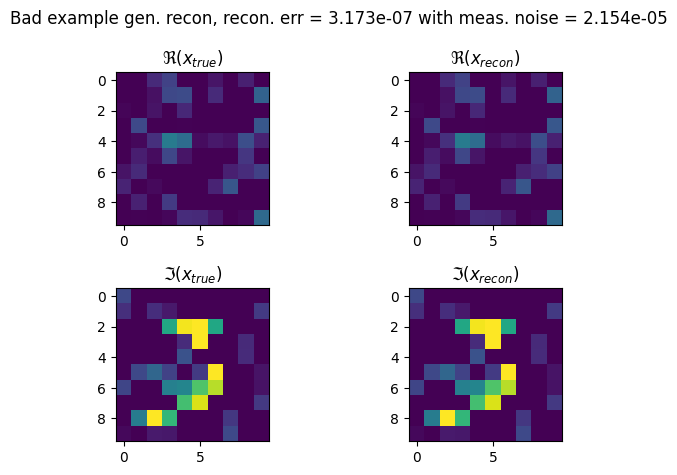

In [69]:
# temporary save 
errors_i_in = np.copy(errors_i)
xhats_i_in  = np.copy(xhats_i)

errors_g_in = np.copy(errors_g)
xhats_g_in  = np.copy(xhats_g)

errors_c_in = np.copy(errors_c)
xhats_c_in  = np.copy(xhats_c)

noise_index = 1
sample_index = 8

print(f"noise: {sigmas[0]:.8e}")
print(errors_g_in[noise_index,:])

# visualize a bad example
fig, ax = plt.subplots(2,2)

ax[0,0].imshow(np.real(x_export[noise_index, sample_index,:].reshape((nx,nx))),clim=[0,1])
ax[0,0].set_title(r'$\Re(x_{true})$')
ax[1,0].imshow(np.imag(x_export[noise_index, sample_index,:].reshape((nx,nx))),clim=[0,1])
ax[1,0].set_title(r'$\Im(x_{true})$')
ax[0,1].imshow(np.real(xhats_g_in[noise_index, sample_index,:].reshape((nx,nx))),clim=[0,1])
ax[0,1].set_title(r'$\Re(x_{recon})$')
ax[1,1].imshow(np.imag(xhats_g_in[noise_index, sample_index,:].reshape((nx,nx))),clim=[0,1])
ax[1,1].set_title(r'$\Im(x_{recon})$')

fig.suptitle(rf"Bad example gen. recon, recon. err = {errors_g_in[noise_index, sample_index]:.3e} with meas. noise = {sigmas[noise_index]:.3e}")
fig.tight_layout()

In [145]:
np.save('indistr_arctan.npy', x_export)
np.save('G_recon_errors', errors_g_in)
np.save('G_recon_xhats', xhats_g_in)

In [46]:
for i in range(len(sigmas)):
    print(f"For noise level {sigmas[i]:.8e}  |  Mean error {np.mean(errors_i[i, :]):.6e}")


For noise level 1.00000000e-06  |  Mean error 1.362430e-01
For noise level 2.15443469e-05  |  Mean error 1.331019e-01
For noise level 4.64158883e-04  |  Mean error 1.236873e-01
For noise level 1.00000000e-02  |  Mean error 1.581800e-01
For noise level 2.15443469e-01  |  Mean error 1.392025e-01
For noise level 4.64158883e+00  |  Mean error 1.937654e-01
For noise level 1.00000000e+02  |  Mean error 6.466761e-01
For noise level 2.15443469e+03  |  Mean error 1.233730e+00
For noise level 4.64158883e+04  |  Mean error 1.738279e+00
For noise level 1.00000000e+06  |  Mean error 1.733459e+00


In [ ]:
print(f"noise: {sigmas[2]:.8e}")
print(errors_i[2,3])

noise: 4.64158883e-04
0.0783090325708439


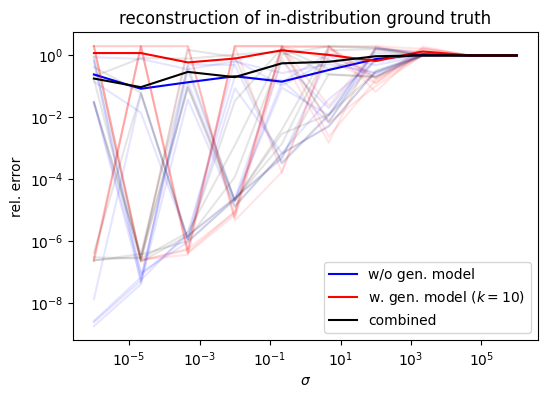

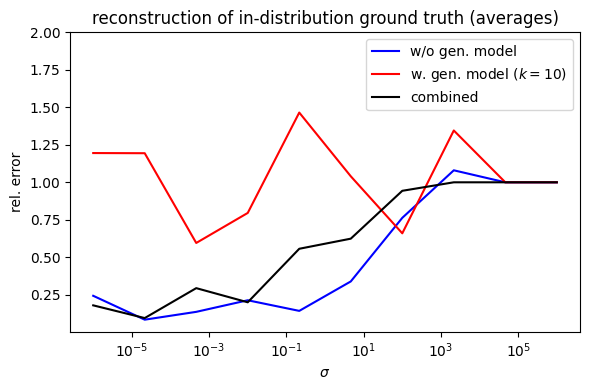

In [56]:
fig, ax = plt.subplots(1, figsize = (6,4))

ax.loglog(sigmas, np.mean(errors_i,axis=1), 'b', label='w/o gen. model')
ax.loglog(sigmas, errors_i, 'b', alpha=1/ns)

ax.loglog(sigmas, np.mean(errors_g,axis=1), 'r', label='w. gen. model ($k=$%d)'%k)
ax.loglog(sigmas, errors_g, 'r', alpha=1/ns)

ax.loglog(sigmas, np.mean(errors_c,axis=1), 'k', label='combined')
ax.loglog(sigmas, errors_c, 'k', alpha=1/ns)

# for scatter plot version

# for i in range(errors_i.shape[1]):
#     ax.scatter(sigmas, errors_i[:, i], color='b', alpha=1/ns, s=10)

# for i in range(errors_g.shape[1]):
#     ax.scatter(sigmas, errors_g[:, i], color='r', alpha=1/ns, s=10)

# for i in range(errors_c.shape[1]):
#     ax.scatter(sigmas, errors_c[:, i], color='k', alpha=1/ns, s=10)

ax.set_xlabel(r'$\sigma$')
ax.set_ylabel('rel. error')
ax.set_title('reconstruction of in-distribution ground truth')
ax.legend()
#plt.savefig('MNIST_100_decoder_indistribution_lines.png', dpi=300)
plt.show()


# only averages
fig, ax = plt.subplots(1, figsize = (6,4))

ax.plot(sigmas, np.mean(errors_i, axis=1), 'b', label='w/o gen. model')
ax.plot(sigmas, np.mean(errors_g, axis=1), 'r', label='w. gen. model ($k=$%d)' % k)
ax.plot(sigmas, np.mean(errors_c, axis=1), 'k', label='combined')

ax.set_xlabel(r'$\sigma$')
ax.set_ylabel('rel. error')
ax.set_title('reconstruction of in-distribution ground truth (averages)')

ax.set_xscale('log') 
ax.set_ylim([0.001, 2])

# Optional: tighten x range to only include data
#ax.set_xlim([min(sigmas), max(sigmas)])

ax.legend()
plt.tight_layout()
#plt.savefig('MNIST_100_decoder_indistribution_averages.png', dpi=300)
plt.show()



##### Good and bad samples

In [57]:
# test reconstruction in-distribution with gen. model without measurement noise
ns     = 100

errors_gin = np.zeros(ns)
bias_gin   = np.zeros(ns)
res_gin    = np.zeros(ns)
xhats_gin  = np.zeros((ns, n),dtype='complex')
zhats_gin  = np.zeros((ns, k),dtype='complex')

errors_iin = np.zeros(ns)
xhats_iin  = np.zeros((ns, n),dtype='complex')
#zhats_iin  = np.zeros((ns, k),dtype='complex')

z_indis = np.zeros((ns, k), dtype='complex')
x_indis = np.zeros((ns, n), dtype='complex')
#x_import = np.load('indistribution_ex.npy')

for j in range(ns):
    print("j:", j)

    #ztrue = np.random.uniform(0,2,k) + 1j*np.random.uniform(0,2,k) #uniform
    ztrue = np.random.randn(k) + 1j*np.random.randn(k) # normal
    #ztrue = np.random.uniform(0,2,k) + 2j*np.random.randn(k) # positive real part but imaginary part random

    xtrue = G.eval(ztrue) 

    z_indis[j,:] = ztrue
    x_indis[j,:] = xtrue # allows you to compare outliers later as well
    #xtrue = x_import[i,j,:]

    errors_gin[j], xhats_gin[j,:], yobs, zhats_gin[j,:] = reconstruct(xtrue, A, Astar, G, Gstar, w=1)
    #bias_gin[j], _, _, _ = reconstruct(xtrue, I, Istar, G, Gstar, w=1)
    errors_iin[j], xhats_iin[j,:], _, _ = reconstruct(xtrue, A, Astar, I, Istar, w=1)

    #res_gin[j] = np.linalg.norm(A.eval(G.eval(zhats_gin[j,:]))-yobs)
    

j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
j: 10
j: 11
j: 12
j: 13
j: 14
j: 15
j: 16
j: 17
j: 18
j: 19
j: 20
j: 21
j: 22
j: 23
j: 24
j: 25
j: 26
j: 27
j: 28
j: 29
j: 30
j: 31
j: 32
j: 33
j: 34
j: 35
j: 36
j: 37
j: 38
j: 39
j: 40
j: 41
j: 42
j: 43
j: 44
j: 45
j: 46
j: 47
j: 48
j: 49
j: 50
j: 51
j: 52
j: 53
j: 54
j: 55
j: 56
j: 57
j: 58
j: 59
j: 60
j: 61
j: 62
j: 63
j: 64
j: 65
j: 66
j: 67
j: 68
j: 69
j: 70
j: 71
j: 72
j: 73
j: 74
j: 75
j: 76
j: 77
j: 78
j: 79
j: 80
j: 81
j: 82
j: 83
j: 84
j: 85
j: 86
j: 87
j: 88
j: 89
j: 90
j: 91
j: 92
j: 93
j: 94
j: 95
j: 96
j: 97
j: 98
j: 99


In [58]:
print(np.argmax(errors_iin))
worst = np.argmax(errors_iin)
best = np.argmin(errors_iin)

bad_samples = []
good_samples = []
count = 0
for j in range(len(errors_iin)):
    if errors_iin[j] > 1e-5:
        count+= 1
        bad_samples.append(j)
    else:
        good_samples.append(j)

print(count)
print(bad_samples)
print(good_samples)
print(np.mean(errors_iin[bad_samples]))

x_badsamples = x_indis[bad_samples,:]
x_goodsamples = x_indis[good_samples,:]

z_badsamples = z_indis[bad_samples,:]
z_goodsamples = z_indis[good_samples,:]

46
61
[2, 3, 6, 7, 8, 9, 11, 12, 14, 15, 18, 21, 23, 24, 25, 26, 29, 30, 33, 34, 36, 37, 40, 44, 45, 46, 48, 49, 50, 51, 53, 54, 55, 56, 57, 61, 64, 65, 66, 68, 70, 71, 72, 74, 76, 77, 78, 80, 81, 82, 83, 87, 88, 90, 91, 94, 95, 96, 97, 98, 99]
[0, 1, 4, 5, 10, 13, 16, 17, 19, 20, 22, 27, 28, 31, 32, 35, 38, 39, 41, 42, 43, 47, 52, 58, 59, 60, 62, 63, 67, 69, 73, 75, 79, 84, 85, 86, 89, 92, 93]
0.30134268243183593


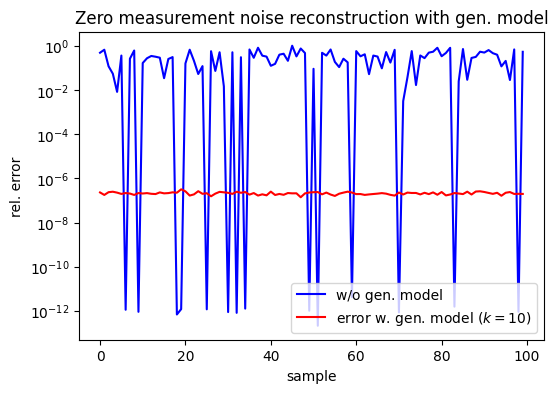

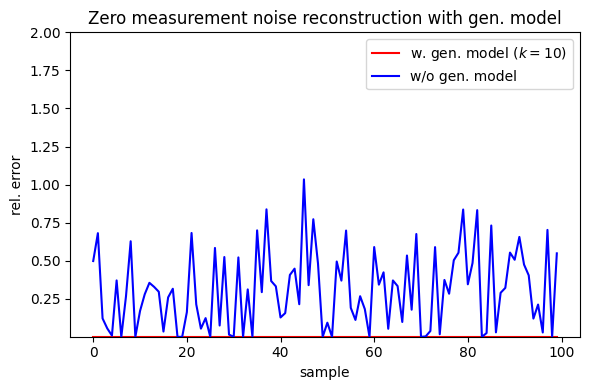

In [43]:
fig, ax = plt.subplots(1, figsize = (6,4))

ax.plot(range(ns), errors_iin, 'b', label='w/o gen. model')
ax.plot(range(ns), errors_gin, 'r', label='error w. gen. model ($k=$%d)'%k)
#ax.plot(range(ns), bias_gin, 'k', label='bias w. gen. model ($k=$%d)'%k)
#ax.plot(range(ns), res_gin, 'g', label='residual')

ax.set_yscale("log")

# for scatter plot version

# for i in range(errors_i.shape[1]):
#     ax.scatter(sigmas, errors_i[:, i], color='b', alpha=1/ns, s=10)

# for i in range(errors_g.shape[1]):
#     ax.scatter(sigmas, errors_g[:, i], color='r', alpha=1/ns, s=10)

# for i in range(errors_c.shape[1]):
#     ax.scatter(sigmas, errors_c[:, i], color='k', alpha=1/ns, s=10)

ax.set_xlabel('sample')
ax.set_ylabel('rel. error')
ax.set_title('Zero measurement noise reconstruction with gen. model')
ax.legend()
#plt.savefig('MNIST_100_decoder_indistribution_lines.png', dpi=300)
plt.show()


# linear
fig, ax = plt.subplots(1, figsize = (6,4))

ax.plot(range(ns), errors_gin, 'r', label='w. gen. model ($k=$%d)' % k)
ax.plot(range(ns), errors_iin, 'b', label='w/o gen. model')

ax.set_xlabel('sample')
ax.set_ylabel('rel. error')
ax.set_title('Zero measurement noise reconstruction with gen. model')

#ax.set_xscale('log') 
ax.set_ylim([0.001, 2])

ax.legend()
plt.tight_layout()
plt.show()

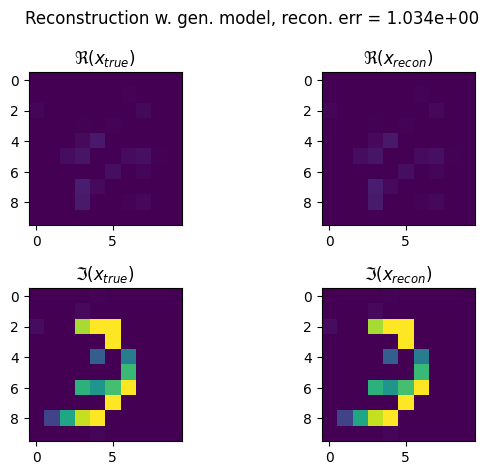

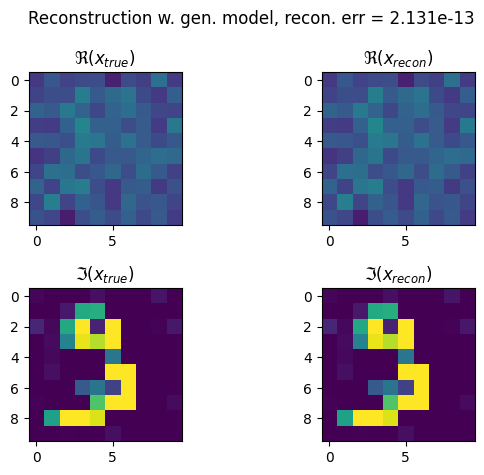

In [44]:
# visualize a bad example
plot_i = worst

fig, ax = plt.subplots(2,2)

ax[0,0].imshow(np.real(x_indis[plot_i,:].reshape((nx,nx))),clim=[0,1])
ax[0,0].set_title(r'$\Re(x_{true})$')
ax[1,0].imshow(np.imag(x_indis[plot_i,:].reshape((nx,nx))),clim=[0,1])
ax[1,0].set_title(r'$\Im(x_{true})$')
ax[0,1].imshow(np.real(xhats_gin[plot_i,:].reshape((nx,nx))),clim=[0,1])
ax[0,1].set_title(r'$\Re(x_{recon})$')
ax[1,1].imshow(np.imag(xhats_gin[plot_i,:].reshape((nx,nx))),clim=[0,1])
ax[1,1].set_title(r'$\Im(x_{recon})$')

fig.suptitle(rf"Reconstruction w. gen. model, recon. err = {errors_iin[plot_i]:.3e}")
fig.tight_layout()

# visualize a good example
plot_i = best

fig, ax = plt.subplots(2,2)

ax[0,0].imshow(np.real(x_indis[plot_i,:].reshape((nx,nx))),clim=[0,1])
ax[0,0].set_title(r'$\Re(x_{true})$')
ax[1,0].imshow(np.imag(x_indis[plot_i,:].reshape((nx,nx))),clim=[0,1])
ax[1,0].set_title(r'$\Im(x_{true})$')
ax[0,1].imshow(np.real(xhats_gin[plot_i,:].reshape((nx,nx))),clim=[0,1])
ax[0,1].set_title(r'$\Re(x_{recon})$')
ax[1,1].imshow(np.imag(xhats_gin[plot_i,:].reshape((nx,nx))),clim=[0,1])
ax[1,1].set_title(r'$\Im(x_{recon})$')

fig.suptitle(rf"Reconstruction w. gen. model, recon. err = {errors_iin[plot_i]:.3e}")
fig.tight_layout()

In [149]:
print(np.mean(x_badsamples, axis=1).shape)
print(np.max(z_goodsamples))
print(np.max(z_badsamples))

(19,)
(3.0083143239965713+1.323294715847047j)
(2.483528597938912+1.3130414904611563j)


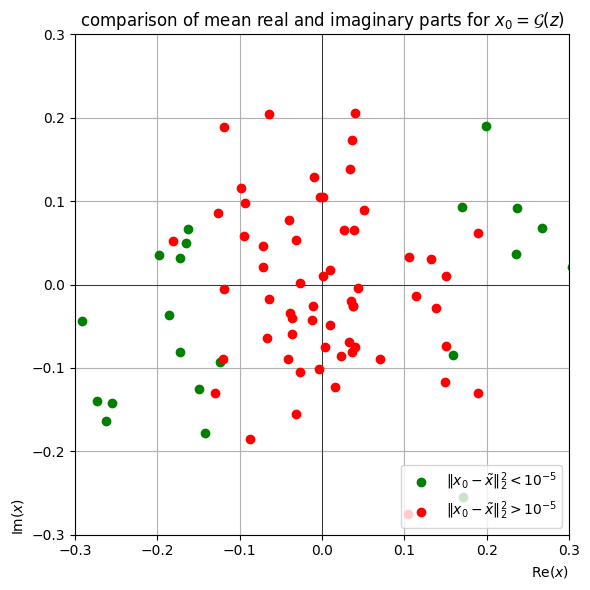

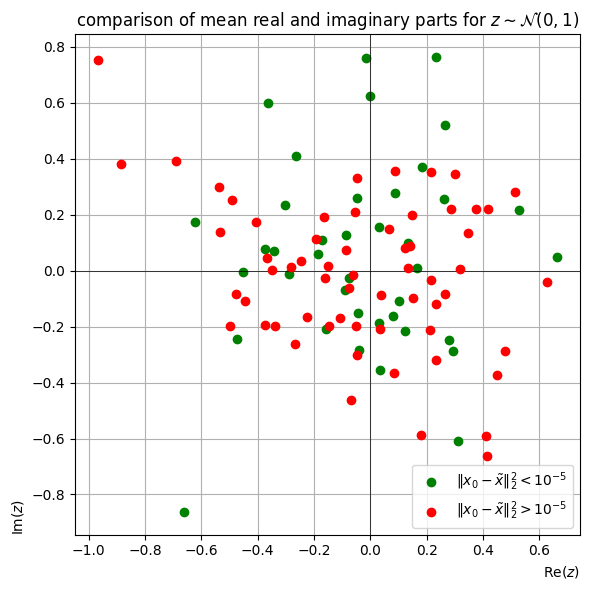

c:\Users\Abel\miniconda3\envs\wtf\lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Abel\miniconda3\envs\wtf\lib\site-packages\matplotlib\collections.py:197: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


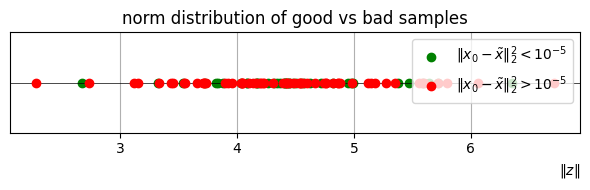

In [ ]:
fig, ax = plt.subplots(1, figsize=(6,6))

ax.scatter(np.mean(np.real(x_goodsamples), axis = 1), np.mean(np.imag(x_goodsamples), axis = 1), color='green', label = r'$\| x_0 - \tilde{x} \|_2^2 < 10^{-5}$', zorder = 2)
ax.scatter(np.mean(np.real(x_badsamples), axis = 1), np.mean(np.imag(x_badsamples), axis = 1), color='red', label = r'$\| x_0 - \tilde{x} \|_2^2 > 10^{-5}$', zorder = 3)

ax.set_title(r"comparison of mean real and imaginary parts for $x_0 = \mathcal{G}(z)$")
ax.set_xlabel(r"Re($x$)", loc='right')
ax.set_ylabel(r"Im($x$)", loc='bottom')
ax.legend(loc = 4)
ax.grid(True, zorder = 1)
ax.set_xlim([-0.3,0.3])
ax.set_ylim([-0.3,0.3])
ax.axhline(y=0, color='black', lw=0.5)
ax.axvline(x=0, color='black', lw=0.5)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, figsize=(6,6))

ax.scatter(np.mean(np.real(z_goodsamples), axis = 1), np.mean(np.imag(z_goodsamples), axis = 1), color='green', label = r'$\| x_0 - \tilde{x} \|_2^2 < 10^{-5}$', zorder = 2)
ax.scatter(np.mean(np.real(z_badsamples), axis = 1), np.mean(np.imag(z_badsamples), axis = 1), color='red', label = r'$\| x_0 - \tilde{x} \|_2^2 > 10^{-5}$', zorder = 3)

ax.set_title(r"comparison of mean real and imaginary parts for $z \sim \mathcal{N}(0,1)$") # don't forget to change
ax.set_xlabel(r"Re($z$)", loc='right')
ax.set_ylabel(r"Im($z$)", loc ='bottom')
ax.legend(loc = 4)
ax.grid(True, zorder = 1)
#ax.set_xlim([-1,1])
#ax.set_ylim([-0.3,0.3])
ax.axhline(y=0, color='black', lw=0.5)
ax.axvline(x=0, color='black', lw=0.5)
plt.tight_layout()
plt.show()


[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10  9 10 10 10 10 10
  9 10  9  9 10 10 10 10 10 10 10 10 10 10 10]
[ 9 10 10 10 10 10 10 10 10 10 10  9 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10  9  9 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10  9 10 10 10 10 10 10 10]


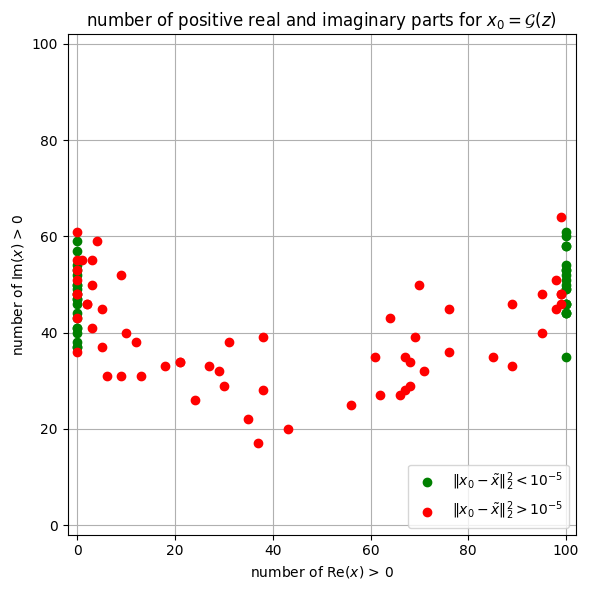

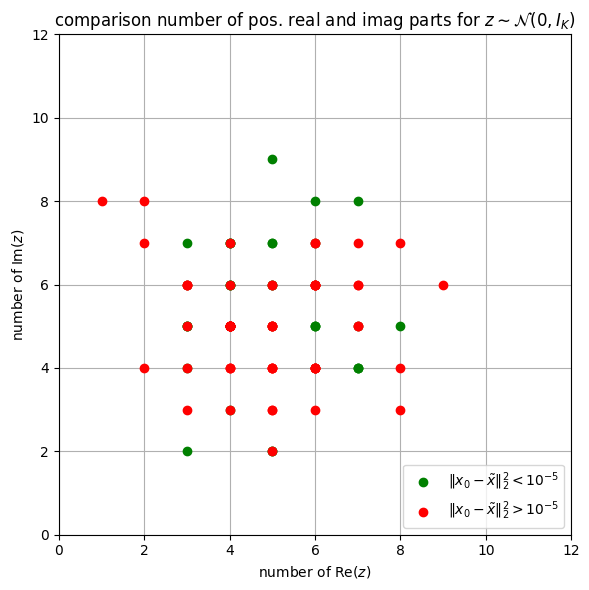

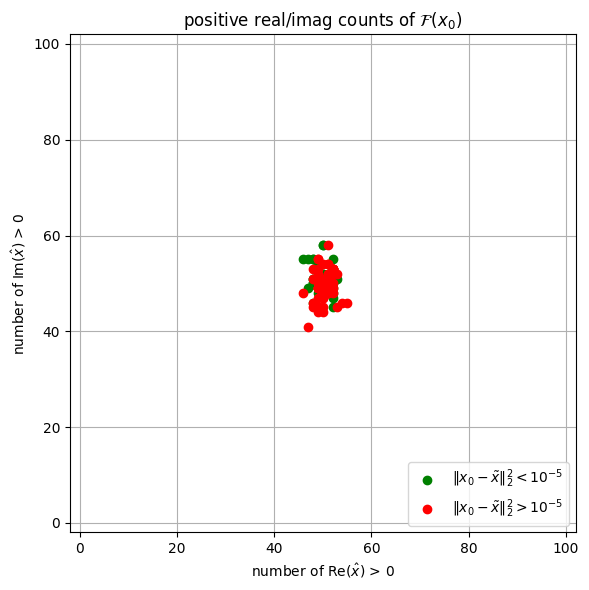

In [61]:
def count_positive_parts(samples):
    real_pos = (np.real(samples) > 0).sum(axis=1)
    imag_pos = (np.imag(samples) > 0).sum(axis=1)
    return np.stack((real_pos, imag_pos), axis=1)

def count_magnitude_threshold(samples, b=0.1):
    above_thresh = (np.abs(samples) > b).sum(axis=1)
    return above_thresh

x_good_pos_counts = count_positive_parts(x_goodsamples)
x_bad_pos_counts = count_positive_parts(x_badsamples)
z_good_pos_counts = count_positive_parts(z_goodsamples)
z_bad_pos_counts = count_positive_parts(z_badsamples)

# fourier parts
xf_goodsamples = fft(x_goodsamples, axis=1)
xf_badsamples = fft(x_badsamples, axis=1)

xf_good_pos_counts = count_positive_parts(xf_goodsamples)
xf_bad_pos_counts = count_positive_parts(xf_badsamples)

# number of values with |z| > b
z_good_abs_counts = count_magnitude_threshold(z_goodsamples)
z_bad_abs_counts = count_magnitude_threshold(z_badsamples)

print(z_good_abs_counts)
print(z_bad_abs_counts)

fig, ax = plt.subplots(1, figsize=(6,6))

ax.scatter(x_good_pos_counts[:,0], x_good_pos_counts[:,1], color='green', label = r'$\| x_0 - \tilde{x} \|_2^2 < 10^{-5}$', zorder = 2)
ax.scatter(x_bad_pos_counts[:,0], x_bad_pos_counts[:,1], color='red', label = r'$\| x_0 - \tilde{x} \|_2^2 > 10^{-5}$', zorder = 3)

ax.set_title(r"number of positive real and imaginary parts for $x_0 = \mathcal{G}(z)$")
ax.set_xlabel(r"number of Re($x$) > 0")
ax.set_ylabel(r"number of Im($x$) > 0")
ax.legend(loc = 4)
ax.grid(True, zorder = 1)
ax.set_xlim([-2,102])
ax.set_ylim([-2,102])
#ax.axhline(y=0, color='black', lw=0.5)
#ax.axvline(x=0, color='black', lw=0.5)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, figsize=(6,6))

ax.scatter(z_good_pos_counts[:,0], z_good_pos_counts[:,1], color='green', label = r'$\| x_0 - \tilde{x} \|_2^2 < 10^{-5}$', zorder = 2)
ax.scatter(z_bad_pos_counts[:,0], z_bad_pos_counts[:,1], color='red', label = r'$\| x_0 - \tilde{x} \|_2^2 > 10^{-5}$', zorder = 3)

ax.set_title(r"comparison number of pos. real and imag parts for $z \sim \mathcal{N}(0,I_K)$")
ax.set_xlabel(r"number of Re($z$)")
ax.set_ylabel(r"number of Im($z$)")
ax.legend(loc = 4)
ax.grid(True, zorder = 1)
ax.set_xlim([0,12])
ax.set_ylim([0,12])
ax.axhline(y=0, color='black', lw=0.5)
ax.axvline(x=0, color='black', lw=0.5)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(xf_good_pos_counts[:, 0], xf_good_pos_counts[:, 1], color='green', label=r'$\| x_0 - \tilde{x} \|_2^2 < 10^{-5}$', zorder=2)
ax.scatter(xf_bad_pos_counts[:, 0], xf_bad_pos_counts[:, 1], color='red', label=r'$\| x_0 - \tilde{x} \|_2^2 > 10^{-5}$', zorder=3)

ax.set_title(r"positive real/imag counts of $\mathcal{F}(x_0)$")
ax.set_xlabel(r"number of Re($\hat{x}$) > 0")
ax.set_ylabel(r"number of Im($\hat{x}$) > 0")
ax.legend(loc=4)
ax.grid(True, zorder=1)
ax.set_xlim([-2, 102])
ax.set_ylim([-2, 102])
plt.tight_layout()
plt.show()

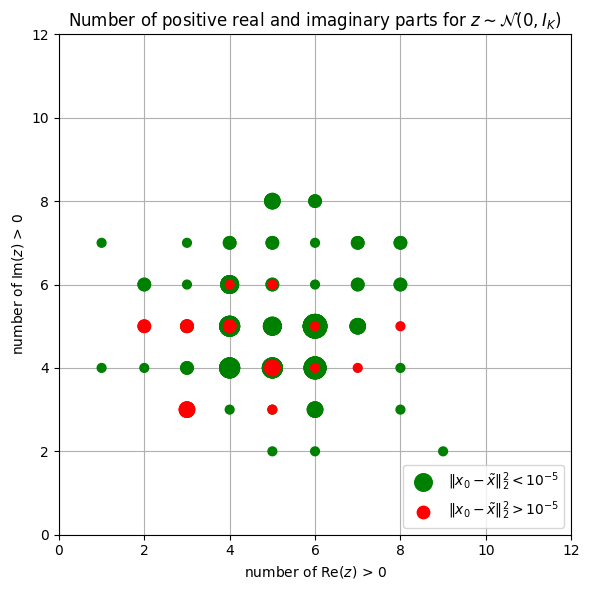

In [59]:
def get_scatter_data_with_sizes(data: np.ndarray):
    # Count occurrences of each (x, y) pair
    unique_points, counts = np.unique(data, axis=0, return_counts=True)
    point_to_count = {tuple(pt): count for pt, count in zip(unique_points, counts)}
    
    # Map back counts to original data
    sizes = np.array([point_to_count[tuple(pt)] for pt in data]) * 40  # Adjust scale
    return data[:, 0], data[:, 1], sizes

fig, ax = plt.subplots(1, figsize=(6,6))

x_good, y_good, s_good = get_scatter_data_with_sizes(z_good_pos_counts)
x_bad, y_bad, s_bad = get_scatter_data_with_sizes(z_bad_pos_counts)

ax.scatter(x_good, y_good, s=s_good, color='green', label=r'$\| x_0 - \tilde{x} \|_2^2 < 10^{-5}$', zorder=2)
ax.scatter(x_bad, y_bad, s=s_bad, color='red', label=r'$\| x_0 - \tilde{x} \|_2^2 > 10^{-5}$', zorder=3)

ax.set_title(r"Number of positive real and imaginary parts for $z \sim \mathcal{N}(0,I_K)$")
ax.set_xlabel(r"number of Re($z$) > 0")
ax.set_ylabel(r"number of Im($z$) > 0")
ax.legend(loc=4)
ax.grid(True, zorder=1)
ax.set_xlim([0, 12])
ax.set_ylim([0, 12])
ax.axhline(y=0, color='black', lw=0.5)
ax.axvline(x=0, color='black', lw=0.5)
plt.tight_layout()
plt.show()


In [17]:
# scan over noise levels with and without generative model on out-of-distribution gt
ns     = 10
sigmas = np.logspace(-6,6,10)

errors_i = np.zeros((len(sigmas),ns))
xhats_i  = np.zeros((len(sigmas),ns, n),dtype='complex')

errors_g = np.zeros((len(sigmas),ns))
xhats_g  = np.zeros((len(sigmas),ns, n),dtype='complex')

errors_c = np.zeros((len(sigmas),ns))
xhats_c  = np.zeros((len(sigmas),ns, n),dtype='complex')

for i in range(len(sigmas)):
    print("i:", i)
    for j in range(ns):
        #print("j:", j)
        xdatatest = datatest[np.random.randint(0,datatest.shape[0])]
        xtrue = xdatatest.flatten()

        # phase object
        # phases = np.random.uniform(0, 2*np.pi, sample_shape)
        # xtrue = np.exp(1j*phases)
        
        errors_i[i,j], xhats_i[i,j,:], _, _ = reconstruct(xtrue, A, Astar, I, Istar, w=1, sigma=sigmas[i], lmbda=sigmas[i])
        errors_g[i,j], xhats_g[i,j,:], _, _ = reconstruct(xtrue, A, Astar, G, Gstar, w=1, sigma=sigmas[i], lmbda=sigmas[i])
        errors_c[i,j], xhats_c[i,j,:], _, _ = reconstruct(xtrue, A, Astar, H, Hstar, w=1, sigma=sigmas[i], lmbda=1e1*sigmas[i])

i: 0
i: 1
i: 2
i: 3
i: 4
i: 5
i: 6
i: 7
i: 8
i: 9


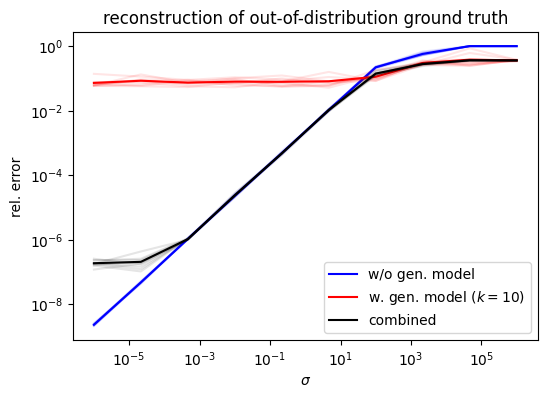

In [18]:
fig, ax = plt.subplots(1, figsize = (6,4))

ax.loglog(sigmas, np.mean(errors_i,axis=1), 'b', label='w/o gen. model')
ax.loglog(sigmas, errors_i, 'b', alpha=1/ns)

ax.loglog(sigmas, np.mean(errors_g,axis=1), 'r', label='w. gen. model ($k=$%d)'%k)
ax.loglog(sigmas, errors_g, 'r', alpha=1/ns)

ax.loglog(sigmas, np.mean(errors_c,axis=1), 'k', label='combined')
ax.loglog(sigmas, errors_c, 'k', alpha=1/ns)

# for scatter plot version

# for i in range(errors_i.shape[1]):
#     ax.scatter(sigmas, errors_i[:, i], color='b', alpha=1/ns, s=10)

# for i in range(errors_g.shape[1]):
#     ax.scatter(sigmas, errors_g[:, i], color='r', alpha=1/ns, s=10)

# for i in range(errors_c.shape[1]):
#     ax.scatter(sigmas, errors_c[:, i], color='k', alpha=1/ns, s=10)

ax.set_xlabel(r'$\sigma$')
ax.set_ylabel('rel. error')
ax.set_title('reconstruction of out-of-distribution ground truth')

ax.legend()
#plt.savefig('MNIST_100_decoder_outdistribution.png', dpi=300)

##### Bias

In [19]:
def generate_noise(n, eta, noise_type="spread", num_localized=None, seed=None):
    """
    Generate noise with the same norm for both spread out and localized noise, ensuring reproducibility with a seed.

    Parameters:
    - n             = int, number of measurements
    - eta           = float, noise standard deviation
    - noise_type    = str, either "spread" or "localized"
    - num_localized = int, number of entries to have noise (only for "localized" type)
    - seed          = int, optional random seed for reproducibility

    Returns:
    - noise         = np.ndarray, noise vector of shape (n,)
    """
    if seed is not None:
        np.random.seed(seed) # generate local seed

    # generate spread noise
    spread_noise = eta * np.random.randn(n)
    spread_norm = np.linalg.norm(spread_noise)

    if noise_type == "spread":
        return spread_noise  
    
    elif noise_type == "localized":
        if num_localized is None:
            num_localized = max(1, n // 4)  #default: 25% of entries affected
        
        noise = np.zeros(n)
        #indices = np.random.choice(n, num_localized, replace=False)  # select noise locations randomly
        index = np.random.randint(0,n-(num_localized-1), dtype=int) # select random first index for noise
        localized_noise = eta * np.random.randn(num_localized)  # generate localized noise gaussian

        # normalize to match spread-out noise norm
        localized_norm = np.linalg.norm(localized_noise)
        if localized_norm > 0:
            localized_noise *= spread_norm / localized_norm  # scale noise to match spread norm entrywise

        noise[index:(index+num_localized)] = localized_noise # add noise to correct entries
        return noise
    
    else:
        raise ValueError("Invalid noise_type. Choose 'spread' or 'localized'.")

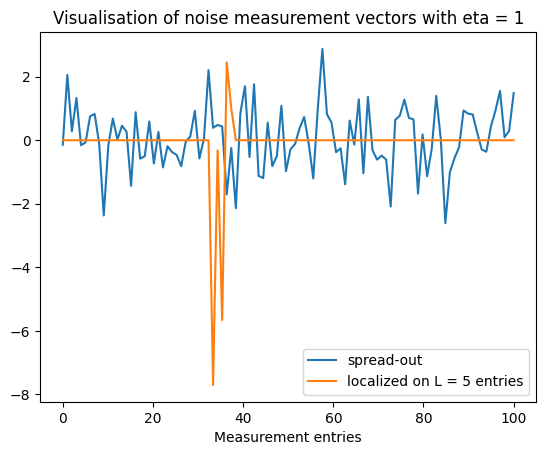

In [24]:
num_loc = n // 20

noise_spread = generate_noise(n, 1, noise_type="spread", num_localized=None, seed=99)
noise_localized = generate_noise(n, 1, noise_type="localized", num_localized=num_loc, seed=99)

plt.figure()
plt.plot(np.linspace(0,n,n), noise_spread, label = 'spread-out')
plt.plot(np.linspace(0,n,n), noise_localized, label = f'localized on L = {num_loc} entries')
plt.title(f"Visualisation of noise measurement vectors with eta = 1")
plt.xlabel("Measurement entries")
plt.legend()
plt.show()

In [18]:
## bias experiments
# different samples for computing bias as the z0-term for in and out-distribution
ns1     = 10

errors_in1 = np.zeros(ns1)
xhats_in1  = np.zeros((ns1, n),dtype='complex')

errors_out1 = np.zeros(ns1)
xhats_out1  = np.zeros((ns1, n),dtype='complex')


for j in range(ns1):
    x_in1 = G.eval(np.random.randn(k) + 1j*np.random.randn(k))
    x_out1 = datatest[np.random.randint(0,datatest.shape[0])].flatten()

    errors_in1[j], xhats_in1[j,:], y_obs_in1, _ = reconstruct(x_in1, I, Istar, G, Gstar, w=1, sigma=0, lmbda=0)
    errors_out1[j], xhats_out1[j,:],y_obs_out1, _ = reconstruct(x_out1, I, Istar, G, Gstar, w=1, sigma=0, lmbda=0)

print(f"%Mean bias in-distr {np.mean(errors_in1):.6e}  |  Std dev {np.std(errors_in1):.6e}")
print(f"%Mean bias out-distr {np.mean(errors_out1):.6e}  |  Std dev {np.std(errors_out1):.6e}")

%Mean bias in-distr 2.782927e-07  |  Std dev 1.120131e-07
%Mean bias out-distr 7.353597e-02  |  Std dev 9.379676e-03


In [ ]:
for i in range(len(etas)):
    print(f"For eta level {etas[i]:.8e}  |  Mean bias {np.mean(bias_in[i, :]):.6e}")


For eta level 1.00000000e-06  |  Mean bas 4.678331e-02
For eta level 2.15443469e-05  |  Mean bas 1.301883e-02
For eta level 4.64158883e-04  |  Mean bas 1.912114e-02
For eta level 1.00000000e-02  |  Mean bas 3.959997e-02
For eta level 2.15443469e-01  |  Mean bas 3.632046e-01
For eta level 4.64158883e+00  |  Mean bas 9.437349e-01
For eta level 1.00000000e+02  |  Mean bas 9.519946e-01
For eta level 2.15443469e+03  |  Mean bas 9.474475e-01
For eta level 4.64158883e+04  |  Mean bas 9.436354e-01
For eta level 1.00000000e+06  |  Mean bas 9.410755e-01


In [27]:
## bias experiments -> maybe write as a function
# different samples for computing bias as the z0-term for in-distribution and varying its misspecification
ns2     = 10
etas2   = np.logspace(-6,6,10)
num_loc = n // 20

bias_in2 = np.zeros((len(etas2),ns2))
bias_unnormalized2 = np.zeros((len(etas2),ns2))
z_differences2 = np.zeros((len(etas2),ns2))
xhats_in2  = np.zeros((len(etas2),ns2, n),dtype='complex')
zhats_in2  = np.zeros((len(etas2),ns2, k),dtype='complex')

ztrue_in2 = np.zeros((len(etas2),ns2,k), dtype='complex')

for i in range(len(etas2)):
    for j in range(ns2):
        ztrue2 = np.random.randn(k) + 1j*np.random.randn(k) #normal
        #ztrue = np.random.uniform(0,2,k) + 1j*np.random.uniform(0,2,k) #uniform

        ztrue_in2[i,j,:] = ztrue2

        x_in = G.eval(ztrue2)
        #art = etas2[i]*(np.random.randn(n)+1j*np.random.randn(n)) # normal
        art = generate_noise(n, etas2[i], noise_type="localized", num_localized=num_loc, seed=99)

        #art = etas[i]*(np.random.uniform(0,2,n)+1j*np.random.uniform(0,2,n)) # uniform

        x_pert = x_in + art

        bias_in2[i,j], xhats_in2[i,j,:], y_obs_in2, zhats_in2[i,j,:] = reconstruct(x_pert, I, Istar, G, Gstar, w=1, sigma=0, lmbda=0)

        z_differences2[i,j]= np.linalg.norm(zhats_in2[i,j,:] - ztrue_in2[i,j,:])/np.linalg.norm(ztrue_in2[i,j,:])
        bias_unnormalized2[i,j] = bias_in2[i,j]*np.linalg.norm(x_pert)

print(f"%Mean bias in-distr {np.mean(bias_in2):.6e}  |  Std dev {np.std(bias_in2):.6e}")

%Mean bias in-distr 5.234123e-01  |  Std dev 4.749652e-01


In [ ]:
for i in range(len(etas2)):
    for j in range(ns2):
        z_differences2[i,j]= np.linalg.norm(zhats_in2[i,j,:] - ztrue_in2[i,j,:])/np.linalg.norm(ztrue_in2[i,j,:])

Text(0.5, 1.0, 'least squares minimization with decoder (cap arctan)')

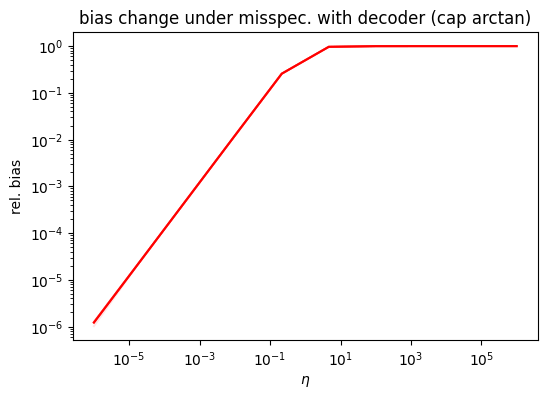

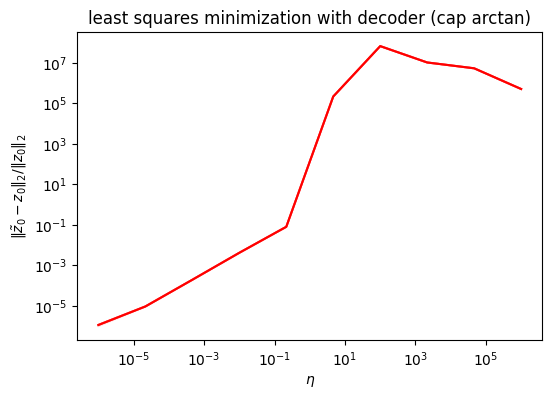

In [28]:
ns = 10

fig, ax = plt.subplots(1, figsize = (6,4))

ax.loglog(etas2, np.mean(bias_in2,axis=1), 'r')
ax.loglog(etas2, bias_in2, 'r', alpha=1/ns)

ax.set_xlabel(r'$\eta$')
ax.set_ylabel('rel. bias')
ax.set_title('bias change under misspec. with decoder (cap arctan)') 
#ax.legend()

fig, ax = plt.subplots(1, figsize = (6,4))

ax.loglog(etas2, np.mean(z_differences2,axis=1), 'r')
ax.loglog(etas2, z_differences2, 'r', alpha=1/ns)

ax.set_xlabel(r'$\eta$')
ax.set_ylabel(r'$\| \tilde{z}_0 - z_0 \|_2 / \| z_0 \|_2$')
ax.set_title(r'least squares minimization with decoder (cap arctan)')

In [35]:
# different samples for computing bias as the zhat-term for IN-distribution of the H-term -> TODO for different noise
etas = np.logspace(-3,3,6)
sigmas = np.logspace(-3,3,3) #np.logspace(-3,3,3)
ns     = 3 # for testing

# MAYBE REDUCE THE NUMBER OF ITERATIONS AS WELL

errors_in   = np.zeros((len(etas),len(sigmas),ns))
bias_in_1   = np.zeros((len(etas),ns)) # G(z0) - x0
bias_in_2   = np.zeros((len(etas),len(sigmas),ns)) # G(ztilde) - x0
xhats_in    = np.zeros((len(etas),len(sigmas),ns,n),dtype='complex')
zcurly0_in  = np.zeros((len(etas),ns,k), dtype='complex')             #z_tilde0 from gen. approach
zcurly_in   = np.zeros((len(etas),len(sigmas),ns,k), dtype='complex') #z_tilde from combined approach
ztrue_in    = np.zeros((len(etas),ns,k), dtype='complex')             #z0

z_diff_1    = np.zeros((len(etas),len(sigmas),ns))                    #||ztilde - ztilde0 ||
z_diff_2    = np.zeros((len(etas),len(sigmas),ns))                    #||ztilde - z0 ||
z_diff_G    = np.zeros((len(etas),ns))                                #||ztilde0 - z0 ||

for i in range(len(etas)):
    print("i", i)
    for j in range(ns):
        print("j", j)
        ztrue = np.random.randn(k) + 1j*np.random.randn(k)
        ztrue_in[i,j,:] = ztrue

        x_in = G.eval(ztrue)
        art = etas[i]*(np.random.randn(n)+1j*np.random.randn(n)) # normal
        #art = etas[i]*(np.random.uniform(0,2,n)+1j*np.random.uniform(0,2,n)) # uniform

        x_pert = x_in + art
         
        bias_in_1[i,j], _, _, zcurly0_in[i,j,:] = reconstruct(x_pert, I, Istar, G, Gstar, w=1, sigma=0, lmbda=0)

        z_diff_G[i,j]= np.linalg.norm(zcurly0_in[i,j,:] - ztrue_in[i,j,:])/np.linalg.norm(ztrue_in[i,j,:])

        for l in range(len(sigmas)):
            print("l", l)
            errors_in[i,l,j], xhats_in[i,l,j,:], _, x1x2_in = reconstruct(x_pert, A, Astar, H, Hstar, w=1, sigma=sigmas[l], lmbda=1)

            x2_in = x1x2_in[k:]
            zcurly_in[i,l,j,:] = x1x2_in[:k]
            G_z_temp = xhats_in[i,l,j,:] - x2_in
            phi = np.mean(np.angle(x_pert/G_z_temp)) # angle correction now has to happen outside of the reconstruct function
            G_z_in = np.exp(1j*phi)*G_z_temp

            bias_in_2[i,l,j] = np.linalg.norm(G_z_in - x_pert)/np.linalg.norm(x_pert)

            z_diff_1[i,l,j] = np.linalg.norm(zcurly_in[i,l,j,:] - zcurly0_in[i,j,:])/np.linalg.norm(ztrue_in[i,j,:]) # not sure if should normalize
            z_diff_2[i,l,j] = np.linalg.norm(zcurly_in[i,l,j,:] - ztrue_in[i,j,:])/np.linalg.norm(ztrue_in[i,j,:])
        


i 0
j 0
l 0
l 1
l 2
j 1
l 0
l 1
l 2
j 2
l 0
l 1
l 2
i 1
j 0
l 0
l 1
l 2
j 1
l 0
l 1
l 2
j 2
l 0
l 1
l 2
i 2
j 0
l 0
l 1
l 2
j 1
l 0
l 1
l 2
j 2
l 0
l 1
l 2
i 3
j 0
l 0
l 1
l 2
j 1
l 0
l 1
l 2
j 2
l 0
l 1
l 2
i 4
j 0
l 0
l 1
l 2
j 1
l 0
l 1
l 2
j 2
l 0
l 1
l 2
i 5
j 0
l 0
l 1
l 2
j 1
l 0
l 1
l 2
j 2
l 0
l 1
l 2


In [44]:
for i in range(len(etas)):
    print(rf"for $\eta[{i}]")
    for j in range(ns):
        print(f"for sample [{j}]")
        print(rf"the value of the bias was ", bias_in_1[i,j])
        print(rf"the z-diff $\| \tilde{{z}}_0 - z_0 \|_2 / \| z_0 \|_2$ was", z_diff_G[i,j])
        for l in range(len(sigmas)):
            print(rf"for $\sigma[{l}]$")
            print(rf"the value of the combined bias was", bias_in_2[i,l,j])
            print(rf"the z-diff $\| \tilde{{z}} - \tilde{{z}}_0 \|_2 / \| z_0 \|_2$ was", z_diff_1[i,l,j])
            print(rf"the z-diff $\| \tilde{{z}} - z_0 \|_2 / \| z_0 \|_2$ was ", z_diff_2[i,l,j])

print("\n\n\n")

for i in range(len(etas)):
    print(rf"for $\eta[{i}]")
    print(rf"the mean value of the bias was ", np.mean(bias_in_1,axis=1)[i])
    print(rf"the mean value of z-diff $\| \tilde{{z}}_0 - z_0 \|_2 / \| z_0 \|_2$ was", np.mean(z_diff_G, axis=1)[i])
    for l in range(len(sigmas)):
        print(rf"for $\sigma[{l}]$")
        print(rf"the value of the combined bias was", np.mean(bias_in_2[:,l,:], axis=1)[l])
        print(rf"the mean value of the z-diff $\| \tilde{{z}} - \tilde{{z}}_0 \|_2 / \| z_0 \|_2$ was", np.mean(z_diff_1[:,l,:],axis=1)[l])
        print(rf"the mean value of the z-diff $\| \tilde{{z}} - z_0 \|_2 / \| z_0 \|_2$ was ", np.mean(z_diff_2[:,l,:],axis=1)[l])

np.save('decoder_bias1.npy', bias_in_1)
np.save('decoder_bias2.npy', bias_in_2)
np.save('decoder_zdiff_G.npy', z_diff_G)
np.save('decoder_zdiff_1.npy', z_diff_1)
np.save('decoder_zdiff_2.npy', z_diff_2)


for $\eta[0]
for sample [0]
the value of the bias was  0.002209287180492888
the z-diff $\| \tilde{z}_0 - z_0 \|_2 / \| z_0 \|_2$ was 0.0007199740248266739
for $\sigma[0]$
the value of the combined bias was 0.25856915431104777
the z-diff $\| \tilde{z} - \tilde{z}_0 \|_2 / \| z_0 \|_2$ was 0.609643310194653
the z-diff $\| \tilde{z} - z_0 \|_2 / \| z_0 \|_2$ was  0.609647895971009
for $\sigma[1]$
the value of the combined bias was 0.2655306738793342
the z-diff $\| \tilde{z} - \tilde{z}_0 \|_2 / \| z_0 \|_2$ was 0.6216470699890291
the z-diff $\| \tilde{z} - z_0 \|_2 / \| z_0 \|_2$ was  0.6216558136342948
for $\sigma[2]$
the value of the combined bias was 1.6198819300120866
the z-diff $\| \tilde{z} - \tilde{z}_0 \|_2 / \| z_0 \|_2$ was 1.039674417059801
the z-diff $\| \tilde{z} - z_0 \|_2 / \| z_0 \|_2$ was  1.0396263311944614
for sample [1]
the value of the bias was  0.0026072158334756665
the z-diff $\| \tilde{z}_0 - z_0 \|_2 / \| z_0 \|_2$ was 0.0014973215292541557
for $\sigma[0]$
the val

Text(0.5, 0.98, 'error latent vectors resulting from modelfitting (cap arctan)')

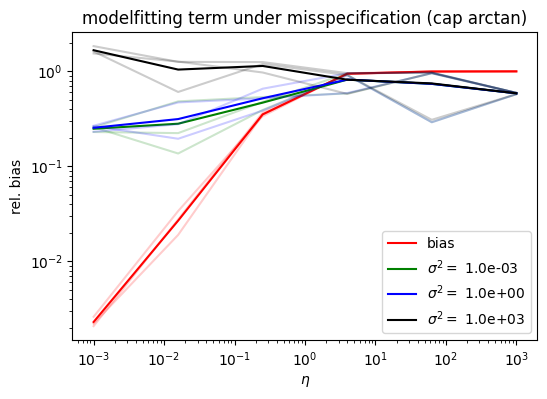

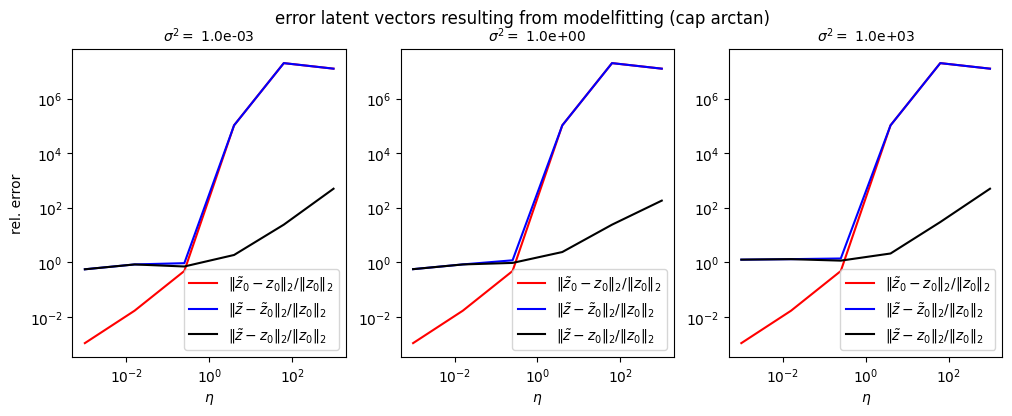

In [40]:
fig, ax = plt.subplots(1, figsize = (6,4))

ax.loglog(etas, np.mean(bias_in_1,axis=1), 'r', label=f'bias')
ax.loglog(etas, bias_in_1, 'r', alpha=1/5)

ax.loglog(etas, np.mean(bias_in_2[:,0,:],axis=1), 'g', label=fr'$\sigma^2 =$ {sigmas[0]:.1e}')
ax.loglog(etas, bias_in_2[:,0,:], 'g', alpha=1/5)

ax.loglog(etas, np.mean(bias_in_2[:,1,:],axis=1), 'b', label=fr'$\sigma^2 =$ {sigmas[1]:.1e}')
ax.loglog(etas, bias_in_2[:,1,:], 'b', alpha=1/5)

ax.loglog(etas, np.mean(bias_in_2[:,2,:],axis=1), 'k', label=fr'$\sigma^2 =$ {sigmas[2]:.1e}')
ax.loglog(etas, bias_in_2[:,2,:], 'k', alpha=1/5)

# ax.loglog(etas, np.mean(bias_in_2[:,3,:],axis=1), 'y', label=f'sigma^2 = {sigmas[3]}')

# ax.loglog(etas, np.mean(bias_in_2[:,4,:],axis=1), 'b', label=f'sigma^2 = {sigmas[4]}')


ax.set_xlabel(r'$\eta$')
ax.set_ylabel('rel. bias')
ax.set_title('modelfitting term under misspecification (cap arctan)')

ax.legend()

#z_diff_1[i,l,j] = np.linalg.norm(zcurly_in[i,l,j,:] - zcurly0_in[i,j,:])/np.linalg.norm(ztrue_in[i,j,:]) # not sure if should normalize
#z_diff_1[i,l,j] = np.linalg.norm(zcurly_in[i,l,j,:] - ztrue_in[i,j,:])/np.linalg.norm(ztrue_in[i,j,:])

fig, ax = plt.subplots(1,3, figsize = (12,4))

ax[0].loglog(etas, np.mean(z_diff_G, axis=1), 'r', label=r'$\| \tilde{z}_0 - z_0 \|_2 / \| z_0 \|_2$')
ax[0].loglog(etas, np.mean(z_diff_1[:,0,:],axis=1), 'b', label=r'$\| \tilde{z} - \tilde{z}_0 \|_2 / \| z_0 \|_2$')
#ax[0].loglog(etas, z_diff_1[:,0,:], 'b', alpha=1/ns)
ax[0].loglog(etas, np.mean(z_diff_2[:,0,:],axis=1), 'k', label=r'$\| \tilde{z} - z_0 \|_2 / \| z_0 \|_2$')
ax[0].set_title(fr'$\sigma^2 =$ {sigmas[0]:.1e}', fontsize=10)
ax[0].set_xlabel(r'$\eta$')
ax[0].set_ylabel('rel. error')
ax[0].legend()

ax[1].loglog(etas, np.mean(z_diff_G, axis=1), 'r', label=r'$\| \tilde{z}_0 - z_0 \|_2 / \| z_0 \|_2$')
ax[1].loglog(etas, np.mean(z_diff_1[:,1,:],axis=1), 'blue', label=r'$\| \tilde{z} - \tilde{z}_0 \|_2 / \| z_0 \|_2$')
ax[1].loglog(etas, np.mean(z_diff_2[:,1,:],axis=1), 'k', label=r'$\| \tilde{z} - z_0 \|_2 / \| z_0 \|_2$')
ax[1].set_title(fr'$\sigma^2 =$ {sigmas[1]:.1e}', fontsize=10)
ax[1].set_xlabel(r'$\eta$')
ax[1].legend()

ax[2].loglog(etas, np.mean(z_diff_G, axis=1), 'r', label=r'$\| \tilde{z}_0 - z_0 \|_2 / \| z_0 \|_2$')
ax[2].loglog(etas, np.mean(z_diff_1[:,2,:],axis=1), 'b', label=r'$\| \tilde{z} - \tilde{z}_0 \|_2 / \| z_0 \|_2$')
ax[2].loglog(etas, np.mean(z_diff_2[:,2,:],axis=1), 'k', label=r'$\| \tilde{z} - z_0 \|_2 / \| z_0 \|_2$')
ax[2].set_title(fr'$\sigma^2 =$ {sigmas[2]:.1e}', fontsize=10)
ax[2].set_xlabel(r'$\eta$')
ax[2].legend()

fig.suptitle('error latent vectors resulting from modelfitting (cap arctan)')


#ax.loglog(etas, z_diff_1[:,1,:], 'c', alpha=1/ns)

# ax.loglog(etas, np.mean(z_diff_1[:,2,:],axis=1), 'm')

# ax.loglog(etas, np.mean(z_diff_1[:,3,:],axis=1), 'g')

# ax.loglog(etas, np.mean(z_diff_1[:,4,:],axis=1), 'y')

#ax.set_xlabel(r'$\eta$')
#ax.set_ylabel(r'$\| \tilde{z}_0 - z_0 \|_2 / \| z_0 \|_2$')
#ax.set_title(r'error latent vectors from modelfitting term (PCA)')
#ax.legend()

In [ ]:
# different samples for computing bias as the zhat-term for OUT-distribution of the H-term
etas = [1]
sigmas = np.logspace(-3,3,5) 
ns     = 5 # for testing

errors_in   = np.zeros((len(etas),len(sigmas),ns))
bias_in_1   = np.zeros((len(etas),ns)) # G(z0) - x0
bias_in_2   = np.zeros((len(etas),len(sigmas),ns)) # G(ztilde) - x0
xhats_in    = np.zeros((len(etas),len(sigmas),ns,n),dtype='complex')
zcurly0_in  = np.zeros((len(etas),ns,k), dtype='complex')             #z_tilde0 from gen. approach
zcurly_in   = np.zeros((len(etas),len(sigmas),ns,k), dtype='complex') #z_tilde from combined approach

z_diff_1    = np.zeros((len(etas),len(sigmas),ns))                    #||ztilde - ztilde0 ||

for i in range(len(etas)):
    print("i", i)
    for j in range(ns):
        print("j", j)

        xdatatest = datatest[np.random.randint(0,datatest.shape[0])]
        x_pert = xdatatest.flatten()
         
        bias_in_1[i,j], _, _, zcurly0_in[i,j,:] = reconstruct(x_pert, I, Istar, G, Gstar, w=1, sigma=0, lmbda=0)

        for l in range(len(sigmas)):
            print("l", l)
            errors_in[i,l,j], xhats_in[i,l,j,:], _, x1x2_in = reconstruct(x_pert, A, Astar, H, Hstar, w=1, sigma=sigmas[l], lmbda=1)

            x2_in = x1x2_in[k:]
            zcurly_in[i,l,j,:] = x1x2_in[:k]
            G_z_temp = xhats_in[i,l,j,:] - x2_in
            phi = np.mean(np.angle(x_pert/G_z_temp)) # angle correction now has to happen outside of the reconstruct function
            G_z_in = np.exp(1j*phi)*G_z_temp

            bias_in_2[i,l,j] = np.linalg.norm(G_z_in - x_pert)/np.linalg.norm(x_pert)

            z_diff_1[i,l,j] = np.linalg.norm(zcurly_in[i,l,j,:] - zcurly0_in[i,j,:])/np.linalg.norm(zcurly0_in[i,j,:]) # not sure if should normalize

%Mean bias out-distr 9.298423e-01  |  Std dev 5.190562e-02
%Mean bias out-distr 5.438300e-01  |  Std dev 2.704658e-02


##### Split datafit and modelfit

In [29]:
# split in a datafitting term and a modelfitting term, IN distribution
ns     = 10
sigmas = np.logspace(-6,6,10)
eta    = 1e3

errors_c    = np.zeros((len(sigmas),ns))
xhats_c     = np.zeros((len(sigmas),ns, n),dtype='complex')
bias_in_h   = np.zeros((len(sigmas),ns))
modelfit_h  = np.zeros((len(sigmas),ns))
modelfit_h_lam   = np.zeros((len(sigmas),ns))
datafit_h   = np.zeros((len(sigmas),ns))

bias_in_1   = np.zeros((len(sigmas),ns))

zcurly_in   = np.zeros((len(sigmas),ns,k), dtype='complex') #z_tilde from combined approach

x_export = np.zeros((len(sigmas), ns, n), dtype='complex')
#x_import = np.load('indistribution_ex.npy')

for i in range(len(sigmas)):
    print("i:", i)
    for j in range(ns):
        print("j:", j)
        ztrue = np.random.randn(k) + 1j*np.random.randn(k) # normal
        #ztrue = np.random.uniform(0,2,k) + 1j*np.random.uniform(0,2,k) # uniform

        #x_export[i,j,:] = xtrue # allows you to compare outliers later as well
        #xtrue = x_import[i,j,:]

        x_in = G.eval(ztrue) #here xtrue comes from the generative model
        art = eta*(np.random.randn(n)+1j*np.random.randn(n)) # normal
        xtrue = x_in + art
         
        bias_in_1[i,j], _, _, _ = reconstruct(xtrue, I, Istar, G, Gstar, w=1, sigma=0, lmbda=0)

        errors_c[i,j], xhats_c[i,j,:], yobs_in, x1x2_in = reconstruct(xtrue, A, Astar, H, Hstar, w=1, sigma=sigmas[i], lmbda=10*sigmas[i])

        x2_in = x1x2_in[k:]
        zcurly_in[i,j,:] = x1x2_in[:k]
        G_z_temp = xhats_c[i,j,:] - x2_in
        phi = np.mean(np.angle(xtrue/G_z_temp)) # angle correction now has to happen outside of the reconstruct function
        G_z_in = np.exp(1j*phi)*G_z_temp

        bias_in_h[i,j] = np.linalg.norm(G_z_in - xtrue)/np.linalg.norm(xtrue)
        modelfit_h[i,j] = np.linalg.norm(G_z_in - xhats_c[i,j,:])/np.linalg.norm(xtrue)
        modelfit_h_lam[i,j] = 10*sigmas[i]*np.linalg.norm(G_z_in - xhats_c[i,j,:])/np.linalg.norm(xtrue)

        datafit_h[i,j] = np.linalg.norm(A.eval(xhats_c[i,j,:]) - yobs_in)/np.linalg.norm(xtrue) 


i: 0
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 1
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 2
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 3
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 4
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 5
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 6
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 7
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 8
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 9
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9


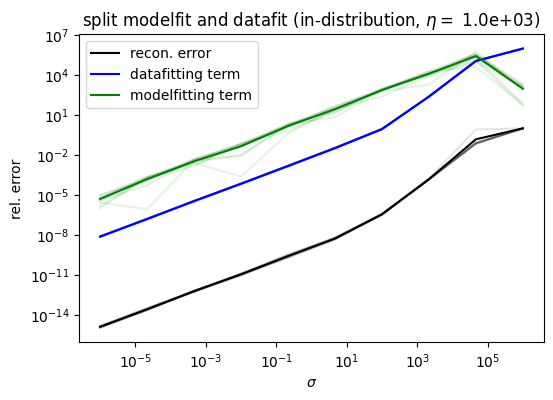

In [30]:
fig, ax = plt.subplots(1, figsize = (6,4))

ax.loglog(sigmas, np.mean(errors_c,axis=1), 'k', label='recon. error')
ax.loglog(sigmas, errors_c, 'k', alpha=1/ns)

# ax.loglog(sigmas, bias_in_1[:,1], 'r', label='bias')

# ax.loglog(sigmas, np.mean(bias_in_h,axis=1), 'k', label='combined bias')
# ax.loglog(sigmas, bias_in_h, 'k', alpha=1/ns)


ax.loglog(sigmas, np.mean(datafit_h,axis=1), 'b', label='datafitting term')
ax.loglog(sigmas, datafit_h, 'b', alpha=1/ns)

# ax.loglog(sigmas, np.mean(modelfit_h,axis=1), 'g', label=r'modelfitting term norm. by $\lambda$')
# ax.loglog(sigmas, modelfit_h, 'g', alpha=1/ns)

ax.loglog(sigmas, np.mean(modelfit_h_lam,axis=1), 'g', label='modelfitting term')
ax.loglog(sigmas, modelfit_h_lam, 'g', alpha=1/ns)

ax.set_xlabel(r'$\sigma$')
ax.set_ylabel('rel. error')
ax.set_title(rf'split modelfit and datafit (in-distribution, $\eta = $ {eta:.1e})')
ax.legend()


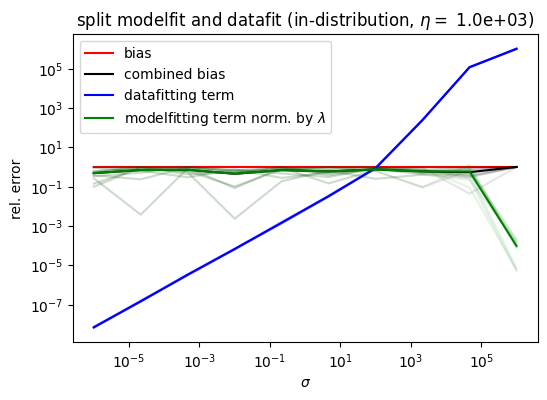

In [31]:
fig, ax = plt.subplots(1, figsize = (6,4))

# ax.loglog(sigmas, np.mean(errors_c,axis=1), 'k', label='recon. error')
# ax.loglog(sigmas, errors_c, 'k', alpha=1/ns)

ax.loglog(sigmas, bias_in_1[:,1], 'r', label='bias')

ax.loglog(sigmas, np.mean(bias_in_h,axis=1), 'k', label='combined bias')
ax.loglog(sigmas, bias_in_h, 'k', alpha=1/ns)


ax.loglog(sigmas, np.mean(datafit_h,axis=1), 'b', label='datafitting term')
ax.loglog(sigmas, datafit_h, 'b', alpha=1/ns)

ax.loglog(sigmas, np.mean(modelfit_h,axis=1), 'g', label=r'modelfitting term norm. by $\lambda$')
ax.loglog(sigmas, modelfit_h, 'g', alpha=1/ns)

# ax.loglog(sigmas, np.mean(modelfit_h_lam,axis=1), 'g', label='modelfitting term')
# ax.loglog(sigmas, modelfit_h_lam, 'g', alpha=1/ns)

ax.set_xlabel(r'$\sigma$')
ax.set_ylabel('rel. error')
ax.set_title(rf'split modelfit and datafit (in-distribution, $\eta = $ {eta:.1e})')
ax.legend()


In [40]:
# split in a datafitting term and a modelfitting term, OUT distribution
ns     = 10
sigmas = np.logspace(-6,6,10)

errors_g = np.zeros((len(sigmas),ns))
xhats_g  = np.zeros((len(sigmas),ns, n),dtype='complex')

errors_c    = np.zeros((len(sigmas),ns))
xhats_c     = np.zeros((len(sigmas),ns, n),dtype='complex')
bias_out_h   = np.zeros((len(sigmas),ns))
modelfit_h  = np.zeros((len(sigmas),ns))
datafit_h   = np.zeros((len(sigmas),ns))

modelfit_h_lam   = np.zeros((len(sigmas),ns))

bias_out_1   = np.zeros((len(sigmas),ns)) # G(z0) - x0

zcurly_out   = np.zeros((len(sigmas),ns,k), dtype='complex') #z_tilde from combined approach

x_export = np.zeros((len(sigmas), ns, n), dtype='complex')
#x_import = np.load('indistribution_ex.npy')

for i in range(len(sigmas)):
    print("i:", i)
    for j in range(ns):
        print("j:", j)
        
        xtrue = datatest[np.random.randint(0,datatest.shape[0])].flatten()

        #x_export[i,j,:] = xtrue # allows you to compare outliers later as well
        #xtrue = x_import[i,j,:]

        errors_c[i,j], xhats_c[i,j,:], yobs_out, x1x2_out = reconstruct(xtrue, A, Astar, H, Hstar, w=1, sigma=sigmas[i], lmbda=1e1*sigmas[i])
        bias_out_1[i,j], _, _, _ = reconstruct(xtrue, I, Istar, G, Gstar, sigma=0, lmbda=0)

        x2_out = x1x2_out[k:]
        zcurly_out[i,j,:] = x1x2_out[:k]
        G_z_temp = xhats_c[i,j,:] - x2_out
        phi = np.mean(np.angle(xtrue/G_z_temp)) # angle correction now has to happen outside of the reconstruct function
        G_z_out = np.exp(1j*phi)*G_z_temp

        bias_out_h[i,j] = np.linalg.norm(G_z_out - xtrue)/np.linalg.norm(xtrue)
        modelfit_h[i,j] = np.linalg.norm(G_z_out - xhats_c[i,j,:])/np.linalg.norm(xtrue) #np.linalg.norm(xhats_c[i,j,:])
        datafit_h[i,j] = np.linalg.norm(A.eval(xhats_c[i,j,:]) - yobs_out)/np.linalg.norm(xtrue) #np.linalg.norm(yobs_out) # no idea about the normalization
        
        modelfit_h_lam[i,j] = 10*sigmas[i]*np.linalg.norm(G_z_in - xhats_c[i,j,:])/np.linalg.norm(xtrue)



i: 0
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 1
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 2
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 3
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 4
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 5
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 6
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 7
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 8
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 9
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9


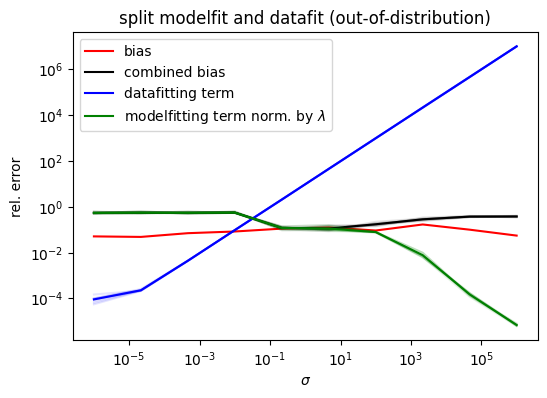

In [42]:
fig, ax = plt.subplots(1, figsize = (6,4))

# ax.loglog(sigmas, np.mean(errors_c,axis=1), 'k', label='recon. error')
# ax.loglog(sigmas, errors_c, 'k', alpha=1/ns)

ax.loglog(sigmas, bias_out_1[:,1], 'r', label='bias')

ax.loglog(sigmas, np.mean(bias_out_h,axis=1), 'k', label='combined bias')
ax.loglog(sigmas, bias_out_h, 'k', alpha=1/ns)

ax.loglog(sigmas, np.mean(datafit_h,axis=1), 'b', label='datafitting term')
ax.loglog(sigmas, datafit_h, 'b', alpha=1/ns)

ax.loglog(sigmas, np.mean(modelfit_h,axis=1), 'g', label=r'modelfitting term norm. by $\lambda$')
ax.loglog(sigmas, modelfit_h, 'g', alpha=1/ns)

# ax.loglog(sigmas, np.mean(modelfit_h_lam,axis=1), 'g', label='modelfitting term')
# ax.loglog(sigmas, modelfit_h_lam, 'g', alpha=1/ns)

ax.set_xlabel(r'$\sigma$')
ax.set_ylabel('rel. error')
ax.set_title('split modelfit and datafit (out-of-distribution)')
ax.legend()


#### Lipschitz estimates

In [340]:
def Lipschitz_est(A, G, samp_amount):
    lip_const_list = []
    perturb_range = [10,1,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6]
    k = G.shape[1]

    x_vals = np.linspace(-10,10,5)
    y_vals = np.linspace(-10,10,5)
    grid_points = [complex(x,y)*np.ones(k) for x in x_vals for y in y_vals]  # 25 total

    for x_lip in grid_points:
        for i in range(samp_amount):
            for j in perturb_range:
                perturb = np.random.normal(0,j,k) + 1j*np.random.normal(0,j,k)
                x_pert = np.linalg.norm(perturb)
                Func_pert = np.linalg.norm((A.eval(G.eval(x_lip)) - A.eval(G.eval(x_lip+perturb))))
                Lip = Func_pert / x_pert
                lip_const_list.append(Lip)

    return lip_const_list

In [33]:
# for G
perturb_range = [1,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6]
lip_const_G = []

for l in range(-10,10,1):
    z_lip = np.ones(k) + 1j*np.ones(k)
    z_lip = l*z_lip # so only on a diagonal line perturbation
    for i in range(100):
        for j in perturb_range:
            perturb = np.random.normal(0,j,k) + 1j*np.random.normal(0,j,k)
            z_pert = np.linalg.norm(perturb)
            G_pert = np.linalg.norm(G.eval(z_lip) - G.eval(z_lip+perturb))
            Lip = G_pert/z_pert
            lip_const_G.append(Lip)

print(np.max(lip_const_G))

5.35097310765614


In [350]:
# for G but with a grid instead of a line
lip_const_G = Lipschitz_est(I,G,100)
print(np.max(lip_const_G))
print(np.mean(lip_const_G))
print(np.min(lip_const_G))

2.9004544850844343
0.48606042549505074
0.10664044206172028


In [354]:
# for A
lip_const_A = Lipschitz_est(A,I,100)
print(np.max(lip_const_A))
print(np.min(lip_const_A))

24879.47294868179
0.0008885041921110165


In [351]:
# for A \circ G
lip_const_AG = Lipschitz_est(A,G,100)
print(np.max(lip_const_AG))
print(np.min(lip_const_AG))

1257.017709370513
39.65890482037023


In [42]:
perturb_range = [1,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6]
lip_const_AG = []

for l in range(-10,10,1):
    z_lip = np.ones(k) + 1j*np.ones(k)
    z_lip = l*z_lip
    for i in range(100):
        for j in perturb_range:
            perturb = np.random.normal(0,j,k)
            z_pert = np.linalg.norm(perturb)
            A_pert = np.linalg.norm(A.eval(G.eval(z_lip)) - A.eval(G.eval(z_lip+perturb)))
            Lip = A_pert/z_pert
            lip_const_AG.append(Lip)

print(np.max(lip_const_AG))

10230.84781461163


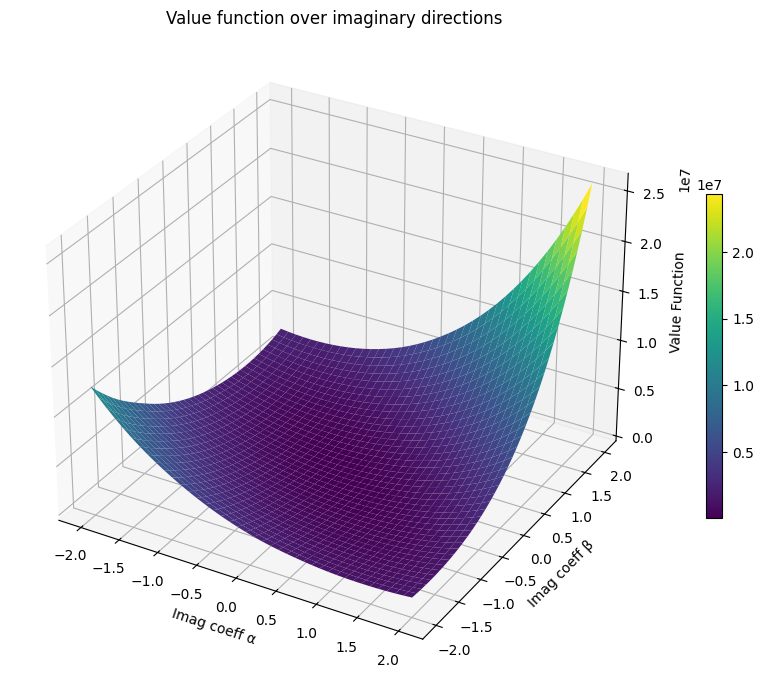

In [194]:
# Parameters
eps = 2.0        # Grid range
res = 40         # Grid resolution

# Define grid in (alpha, beta)
alpha = np.linspace(-eps, eps, res)
beta = np.linspace(-eps, eps, res)
A_grid, B_grid = np.meshgrid(alpha, beta)

# Preallocate value grid
V_grid = np.zeros_like(A_grid)

# Base latent vector (shape = (10,))
zc_init = zhat_ex
zc_base = np.copy(zc_init)  # <-- user-defined complex vector (ℂ^10)

# Choose 2 imaginary directions (user-defined or canonical)
v1 = np.random.randn(10) + 1j * np.random.randn(10)
v2 = np.random.randn(10) + 1j * np.random.randn(10)

# Normalize purely imaginary parts
v1 = 1j * np.imag(v1 / np.linalg.norm(np.imag(v1)))
v2 = 1j * np.imag(v2 / np.linalg.norm(np.imag(v2)))

yobs  = A.eval(xtrue_1D)
lmbda = 0

# Sweep grid and compute val(zc)
for i in range(res):
    for j in range(res):
        zc = zc_base + A_grid[i, j] * v1 + B_grid[i, j] * v2

        xc = G.eval(zc)
        Dx = G.jac(zc)
        Dxstar = Gstar.jac(zc)

        yp = A.eval(xc)
        Dy = A.jac(xc)

        DF = Dxstar.T @ Dy.T + Dx.H @ Dy.H
        res_y = yp - yobs

        val = 0.5 * np.linalg.norm(res_y)**2 + 0.5 * (lmbda**2) * np.linalg.norm(w * zc)**2
        V_grid[i, j] = val.real  # real-valued output

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(A_grid, B_grid, V_grid, cmap='viridis')
ax.set_xlabel('Imag coeff α')
ax.set_ylabel('Imag coeff β')
ax.set_zlabel('Value Function')
fig.colorbar(surf, ax=ax, shrink=0.5)
plt.title("Value function over imaginary directions")
plt.tight_layout()
plt.show()


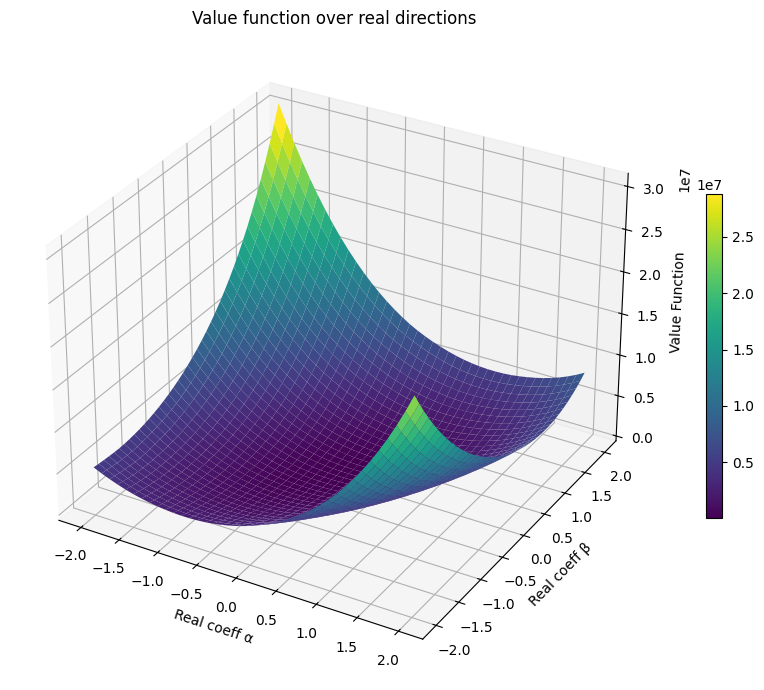

In [ ]:
# Parameters
eps = 2.0        # Grid range
res = 40         # Grid resolution

# Define grid in (alpha, beta)
alpha = np.linspace(-eps, eps, res)
beta = np.linspace(-eps, eps, res)
A_grid, B_grid = np.meshgrid(alpha, beta)

# Preallocate value grid
V_grid = np.zeros_like(A_grid)

# Base latent vector (shape = (10,))
zc_init = zhat_ex
zc_base = np.copy(zc_init)  # <-- user-defined complex vector (ℂ^10)

# Choose 2 real directions (user-defined or canonical)
v1 = np.random.randn(10) + 1j * np.random.randn(10)
v2 = np.random.randn(10) + 1j * np.random.randn(10)

# Normalize purely real parts
v1 = np.real(v1 / np.linalg.norm(np.real(v1)))
v2 = np.real(v2 / np.linalg.norm(np.real(v2)))

# Promote to complex
v1 = v1 + 0j
v2 = v2 + 0j

yobs  = A.eval(xtrue_1D)
lmbda = 0

# Sweep grid and compute val(zc)
for i in range(res):
    for j in range(res):
        zc = zc_base + A_grid[i, j] * v1 + B_grid[i, j] * v2

        xc = G.eval(zc)
        Dx = G.jac(zc)
        Dxstar = Gstar.jac(zc)

        yp = A.eval(xc)
        Dy = A.jac(xc)

        DF = Dxstar.T @ Dy.T + Dx.H @ Dy.H
        res_y = yp - yobs

        val = 0.5 * np.linalg.norm(res_y)**2 + 0.5 * (lmbda**2) * np.linalg.norm(w * zc)**2
        V_grid[i, j] = val.real  # real-valued output

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(A_grid, B_grid, V_grid, cmap='viridis')
ax.set_xlabel('Real coeff α')
ax.set_ylabel('Real coeff β')
ax.set_zlabel('Value Function')
fig.colorbar(surf, ax=ax, shrink=0.5)
plt.title("Value function over real directions")
plt.tight_layout()
plt.show()
